# Generating complex densities using Diffusion models

1. moving to alphabets and number generation using diffusion models
    * We will be using JAX
    * Using U-net blocks for modelling the denoising process

In [1]:
!pip install einops
!pip install dm-tree graphviz imageio[ffmpeg]

In [2]:
import haiku as hk
import jax
import jax.numpy as jnp
import einops
import math
from typing import Iterator, Mapping, Tuple
from copy import deepcopy
import time
from absl import app
import haiku as hk
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow_datasets as tfds
import tensorflow as tf
from functools import partial
import math
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
jax.config.update('jax_platform_name', 'cpu')
Batch = Tuple[np.ndarray, np.ndarray]

2022-11-29 18:16:54.116278: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-29 18:16:54.760127: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64
2022-11-29 18:16:54.760455: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64
2022-11-29 18:16:54.760470: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned abo

In [3]:
train_new_model = True

import os
import os.path as osp

data_paths = osp.join(os.getcwd(), 'saved', 'saved_data')
model_paths = osp.join(os.getcwd(), 'saved','saved_models')

In [4]:
# utils 
import pickle

def load_cached(filename):
    with open(filename, 'rb') as ff:
        return pickle.load(ff)
    
def write_cached(data, filename):
    with open(filename, 'wb') as ff:
        pickle.dump(data, ff, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
# train model

# ####### i am not getting desired results with the cosine beta schedule from the hugging face repo
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = jnp.linspace(0, timesteps, steps)
    alphas_cumprod = jnp.cos(((x / timesteps) + s) / (1 + s) * jnp.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return jnp.clip(betas, 0.0001, 0.05)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return jnp.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return jnp.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = jnp.linspace(-6, 6, timesteps)
    return jnp.sigmoid(betas) * (beta_end - beta_start) + beta_start

In [6]:
# Train model
timesteps = 200
# betas = linear_beta_schedule(timesteps)
betas = cosine_beta_schedule(timesteps)
alphas = 1 - betas
alphas_ = jnp.cumprod(alphas, axis=0)
variance = 1 - alphas_
sd = jnp.sqrt(variance)

alphas_prev_ = jnp.pad(alphas_[:-1], [1, 0], "constant", constant_values=1.0)
sigma_squared_q_t = (1 - alphas) * (1 - alphas_) / (1 - alphas_prev_)
log_sigma_squared_q_t = jnp.log(1-alphas) + jnp.log(1-alphas_) - jnp.log(1-alphas_prev_)
sigma_squared_q_t_corrected = jnp.exp(log_sigma_squared_q_t)

# how to add noise to the data
# @jax.jit
def get_noisy(batch, timestep):
    timestep = einops.repeat(timestep, 'b -> b 28 28 1')
    # we will use the reparameterization trick
    key = jax.random.PRNGKey(42)
    # need to generate new keys everytime
    noise_at_t = jax.random.normal(key, shape=batch.shape)
    added_noise_at_t = jnp.add(batch * jnp.sqrt(alphas_[timestep]), noise_at_t * sd[timestep])
    return added_noise_at_t, noise_at_t

def recover_original(batch, timestep, noise):
    true_data = (batch.sub(noise.mul(sd[timestep]))).div(jnp.sqrt(alphas_[timestep]))
    return true_data

posterior_variance = (betas) * (1 - alphas_prev_) / (1 - alphas_)

## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L196
## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L78
log_posterior_variance = jnp.log(jnp.hstack([posterior_variance[1], posterior_variance[1:]]))

# not sure why we are multiplying by 1/2 here
posterior_variance_corrected = jnp.exp(log_posterior_variance)

([<matplotlib.lines.Line2D at 0x7f019017b040>],
 [<matplotlib.lines.Line2D at 0x7f019011fa90>])

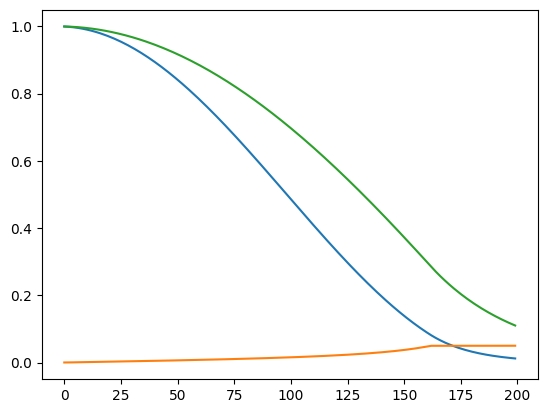

In [7]:
plt.plot(alphas_), plt.plot(posterior_variance_corrected), plt.plot(jnp.sqrt(alphas_))

In [8]:
EMNIST_MEAN = (0.13066373765468597)
EMNIST_STD = (0.30810782313346863)

# adapted from Optax loss -- https://github.com/deepmind/optax/blob/master/optax/_src/loss.py
def huber_loss(
    predictions,
    targets= None,
    delta= 1.):
  """Huber loss, similar to L2 loss close to zero, L1 loss away from zero.
  If gradient descent is applied to the `huber loss`, it is equivalent to
  clipping gradients of an `l2_loss` to `[-delta, delta]` in the backward pass.
  References:
    [Huber, 1964](www.projecteuclid.org/download/pdf_1/euclid.aoms/1177703732)
  Args:
    predictions: a vector of arbitrary shape `[...]`.
    targets: a vector with shape broadcastable to that of `predictions`;
      if not provided then it is assumed to be a vector of zeros.
    delta: the bounds for the huber loss transformation, defaults at 1.
  Returns:
    elementwise huber losses, with the same shape of `predictions`.
  """
  errors = (predictions - targets) if (targets is not None) else predictions
  # 0.5 * err^2                  if |err| <= d
  # 0.5 * d^2 + d * (|err| - d)  if |err| > d
  abs_errors = jnp.abs(errors)
  quadratic = jnp.minimum(abs_errors, delta)
  # Same as max(abs_x - delta, 0) but avoids potentially doubling gradient.
  linear = abs_errors - quadratic
  return jnp.sum(0.5 * quadratic ** 2 + delta * linear, axis=(1, 2, 3))

def load_dataset(
    split: str,
    *,
    is_training: bool,
    batch_size: int,
) -> Iterator[tuple]:
  """Loads the dataset as a generator of batches."""
  # cache the dataset to memory and repeat it indefinitely, epochs have reshuffled ordered data since *reshuffle_each_iteration* defaults to TRUE
  ds = tfds.load('emnist', split=split, as_supervised=True).cache().repeat()
  if is_training:
    # shuffle the batches to improve generalization of the trained network
    ds = ds.shuffle(400 * batch_size, seed=0)
  ds = ds.batch(batch_size)
  return iter(tfds.as_numpy(ds))

# Recommended: this can be jit'd and it should result in faster training time 
@jax.jit
def compute_loss(params: hk.Params, batch: Batch, is_energy_method: bool=False) -> jnp.ndarray:
  """Compute the loss of the network, including L2."""
  x, _, timestep, noise = batch
  pred_data = net.apply(params, x, timestep)
  
  def error_func():
    imp_weight = 1/2 * (1/sigma_squared_q_t_corrected[timestep]) * ((betas[timestep])**2 / (variance[timestep] * alphas[timestep]))
      # loss on prediction
    loss_ = jnp.sum(jnp.multiply(imp_weight, huber_loss(noise, pred_data)))
    return loss_
  
  def energy_func():
    ## Energy function interpretation
    imp_weight = 1/2 * (1/sigma_squared_q_t_corrected[timestep]) * ((betas[timestep])**2 / (alphas[timestep]))
    # loss on prediction
    loss_ = jnp.sum(jnp.multiply(imp_weight, huber_loss(pred_data, jnp.divide(noise, -sd[timestep]))))
    return loss_
    
  loss_ = jax.lax.cond(is_energy_method, energy_func, error_func)
  return loss_ 

@jax.jit
def update(
    params: hk.Params,
    opt_state: optax.OptState,
    batch: Batch,
    is_energy_method: bool=False
) -> Tuple[hk.Params, optax.OptState]:
  """Compute gradients and update the weights"""
  loss_value, grads = jax.value_and_grad(compute_loss)(params, batch, is_energy_method)
  updates, opt_state = opt.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return loss_value, new_params, opt_state

@jax.jit
def ema_update(params, avg_params):
  """Incrementally update parameters via polyak averaging."""
  # Polyak averaging tracks an (exponential moving) average of the past parameters of a model, for use at test/evaluation time.
  return optax.incremental_update(params, avg_params, step_size=0.95)

@jax.jit
def normalize(images):
  # numpy array creation could be moved out of the method
  mean = np.asarray(EMNIST_MEAN)
  std = np.asarray(EMNIST_STD)

  # BUG 3: int8 range is -128 to 127 causing issues with numbers > 127, uint8 / 255. is float64, casting as float32 since that's the type jax prefers
  x = images.astype(jnp.float32) / 255.

  # BUG 4: x /- mean just divides x by -1. * mean without reassignment to x
  x -= mean  # operations uses numpy broadcasting to work correctly
  x /= std 

  return x

@jax.jit
def unnormalize(images):
  mean = np.asarray(EMNIST_MEAN)
  std = np.asarray(EMNIST_STD)

  # BUG 3: int8 range is -128 to 127 causing issues with numbers > 127, uint8 / 255. is float64, casting as float32 since that's the type jax prefers
  x = images.astype(jnp.float32)

  # BUG 4: x /- mean just divides x by -1. * mean without reassignment to x
  x *= std 
  x += mean  # operations uses numpy broadcasting to work correctly
  
  return x*255.
  

In [9]:
# using 20% of the dataset for training, 80% for validation, although it's weird to use maximum available data for validation
# BUG: using 80% train data, since performance improvement beyond 50% wasn't seen with 20% train data
batch_size=128
train = load_dataset("train+test", is_training=True, batch_size=batch_size)

In [10]:
%%capture 
# % matplotlib inline 
# to discard cell output

import matplotlib.animation as animation
import imageio 
from IPython.display import Image
from matplotlib.pyplot import figure

random_index = 22
image = next(train)[0][random_index]
fig = plt.figure()
ims = []
noisy_images, _ = get_noisy(einops.repeat(normalize(image), 'h w c -> b h w c', b=timesteps//10), jnp.arange(1, timesteps, 10))
noisy_images = unnormalize(noisy_images)
for i in range(timesteps//10):
    im = plt.imshow(noisy_images[i], cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=5, blit=True, repeat_delay=3000)
animate.save('gifs/diffusion.gif')

def show_image(img, plt_):
  figure(figsize=(2, 2))
  plt_.imshow(img, cmap="gray", animated=False)

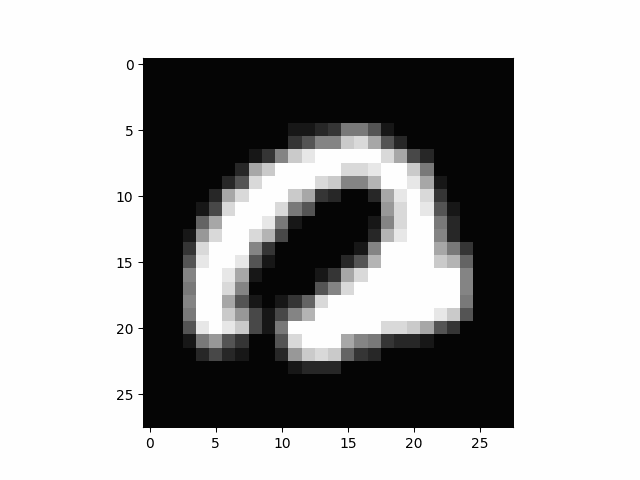

In [11]:
with open('gifs/diffusion.gif','rb') as f:
  display(Image(data=f.read(), format='png'))

In [12]:
# upsample operation in the UNET
class Downsample(hk.Module):
  def __init__(self, output_channels):
    super().__init__()
    self.conv = hk.Conv2D(output_channels=output_channels, kernel_shape=(4, 4), stride=2, padding=[1, 1])
  
  def __call__(self, x):
    return jax.nn.relu(self.conv(x))
  
# Downsample operation in the UNET
class Upsample(hk.Module):
  def __init__(self, output_channels):
    super().__init__()
    self.conv = hk.Conv2D(output_channels=output_channels, kernel_shape=(3, 3), padding='SAME')
  
  def __call__(self, x):
    # scaling image to twice size
    x = einops.repeat(x, 'b h w c -> b (a h) (aa w) c', a=2, aa=2)
    return jax.nn.relu(self.conv(x))
      
class TimeEmbeddings(hk.Module):
  def __init__(self, dim):
    super().__init__()
    half_dim = dim // 2
    embeddings = math.log(10000) / (half_dim - 1)
    self.embeddings = jnp.exp(jnp.arange(half_dim) * -embeddings)

  def __call__(self, timesteps):
      embeddings = self.embeddings
      embeddings = jnp.multiply(timesteps[:, None], embeddings[:, None].T)
      embeddings = jnp.hstack([jnp.sin(embeddings), jnp.cos(embeddings)])
      return embeddings

class Block(hk.Module):
  # a basic resnet style convolutional block
  def __init__(self, output_channels, kernel_size, padding):
    super().__init__()
    self.conv_1 = hk.Conv2D(output_channels=output_channels, kernel_shape=(kernel_size, kernel_size), padding='SAME')
    self.seq = hk.Sequential([
      jax.nn.relu,
      hk.Conv2D(output_channels=output_channels, kernel_shape=(kernel_size, kernel_size), padding='SAME'),
      jax.nn.relu,
    ])
    self.out_conv = hk.Conv2D(output_channels=output_channels, kernel_shape=(1, 1), padding='SAME') 
    # self.time_mlp = None
    dims = output_channels
    self.time_mlp = hk.Sequential([
      TimeEmbeddings(dims),
      hk.Linear(dims*2),
      jax.nn.selu
    ])
    
  def __call__(self, x, timesteps=None):
    x = self.conv_1(x)
    if timesteps is not None and self.time_mlp is not None:
      time_embedding = self.time_mlp(timesteps)
      time_embedding = einops.rearrange(time_embedding, 'b c -> b 1 1 c')
      shift, scale = jnp.split(time_embedding, indices_or_sections=2, axis=-1)
      x = shift + (scale+1)*x
    
    h = self.seq(x)
    return self.out_conv(x) + h

In [13]:
# Unet class to predict noise from a given image
class UNet(hk.Module):
  def __init__(self):
    super().__init__()
    self.init_conv = hk.Conv2D(output_channels=1, kernel_shape = (5,5), padding='SAME')
    self.relu1 = jax.nn.relu
    self.block1 = Block(output_channels=16, kernel_size=3, padding=1)
    self.downsample1 = Downsample(32)
    self.block2 = Block(output_channels=32, kernel_size=3, padding=1)
    self.downsample2 = Downsample(64)
    self.middle_block = Block(output_channels=64, kernel_size=3, padding=1)
    self.upsample1 = Upsample(32)
    self.block3 = Block(output_channels=32, kernel_size=3, padding=1)
    self.upsample2 = Upsample(16)
    self.block4 = Block(output_channels=16, kernel_size=3, padding=1)
    self.out_conv = hk.Conv2D(output_channels=1, kernel_shape = (5,5), padding='SAME')
      
  def __call__(self, x, timesteps):
    h = self.relu1(self.init_conv(x))
    h = self.downsample1(self.block1(h, timesteps))
    h = self.downsample2(self.block2(h, timesteps))
    h = self.upsample1(self.middle_block(h, timesteps))
    h = self.upsample2(self.block3(h, timesteps))
    h = self.block4(h, timesteps)
    h = self.out_conv(h)
    return h

In [14]:
import graphviz

def f(x, timesteps):
  unet = UNet()
  return unet(x, timesteps)

f_t = hk.transform(f)

x = jnp.ones([1, 28, 28, 1])
timesteps_ = jnp.arange(0, 1)

rng = jax.random.PRNGKey(42)
params = f_t.init(rng, x, timesteps_)

# dot = hk.experimental.to_dot(f_t.apply)(params, None, x, timesteps)
# graphviz.Source(dot)

# print(hk.experimental.tabulate(f_t)(x, timesteps_))



---




### Training

In [15]:
# net_fn = UNet()
net = hk.without_apply_rng(f_t)

# Do not change learning rate
opt = optax.adam(1e-3)

# Recommended: param objects should be deepcopied, although in this case it doesn't cause issues
# we draw an input to get shapes.
# params = net.init(jax.random.PRNGKey(42), next(train), timesteps_)
avg_params = deepcopy(params)
opt_state = opt.init(params)

In [16]:
def save(ckpt_dir: str, state, model_name) -> None:
  with open(os.path.join(ckpt_dir, model_name+"_arrays.npy"), "wb") as f:
    for x in jax.tree_util.tree_leaves(state):
         np.save(f, x, allow_pickle=False)
    tree_struct = jax.tree_map(lambda t: 0, state)
  with open(os.path.join(ckpt_dir, model_name+"_tree.pkl"), "wb") as f:
     pickle.dump(tree_struct, f)

def restore(ckpt_dir, model_name):
  with open(os.path.join(ckpt_dir, model_name+"_tree.pkl"), "rb") as f:
    tree_struct = pickle.load(f)
 
  leaves, treedef = jax.tree_util.tree_flatten(tree_struct)
  with open(os.path.join(ckpt_dir, model_name+"_arrays.npy"), "rb") as f:
    flat_state = [np.load(f) for _ in leaves]

  return jax.tree_util.tree_unflatten(treedef, flat_state)

def test_model_save():
  save('saved/saved_models/', avg_params, 'emnist_model')
  avg_params = restore('saved/saved_models/', 'emnist_model')

In [17]:
def show_predicted_image(noisy_image, params, timestep):
  print('time step for image', timestep)
  timestep = jnp.array([timestep])
  pred_noise = net.apply(params, noisy_image, timestep)
  pred_image = noisy_image/jnp.sqrt(alphas_[timestep]) - pred_noise*sd[timestep]/jnp.sqrt(alphas_[timestep])
  _, (p1, p2) = plt.subplots(1, 2)
  show_image(unnormalize(pred_image[0]), p1)
  show_image(unnormalize(noisy_image[0]), p2)
  plt.show()
  return huber_loss(noisy_image, pred_image)
  
# show random images
# show_predicted_image(x, avg_params, 10)

time step for image 199


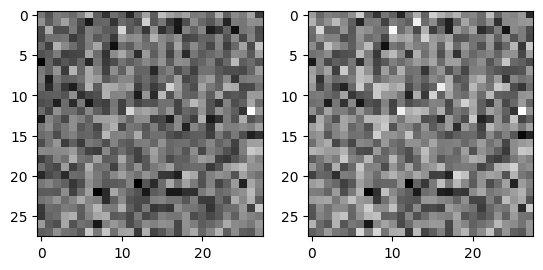

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

[5118.4946]


In [18]:
def test_loss_fn():
  b, l = next(train)
  b = normalize(b)
  loss_ = []
  huber_loss_ = []
  huber_loss_weighted = []
  imp_weight_ = []
  model_huber_loss = []
  for i in range(1, timesteps):
    tt = jnp.array([i])
    data_noisy_temp, noise_temp = get_noisy(b, tt)
    loss_.append(jax.device_get(compute_loss(avg_params, [einops.rearrange(data_noisy_temp[0], 'h w c -> 1 h w c'), jax.nn.one_hot(l, 63), tt, 
                                                          einops.rearrange(noise_temp[0], 'h w c -> 1 h w c')], False)))
    huber_loss__ = huber_loss(data_noisy_temp[0:2], b[0:2])
    huber_loss_.append(huber_loss__)
    
    imp_weight = 1/2 * (1/sigma_squared_q_t_corrected[tt]) * ((betas[tt])**2 / (variance[tt] * alphas[tt]))
    # loss on prediction
    huber_loss_weighted.append(jnp.sum(jnp.multiply(imp_weight, huber_loss__)))
    imp_weight_.append(imp_weight)
    
    pp = net.apply(avg_params, einops.rearrange(data_noisy_temp[0], 'h w c -> 1 h w c'), tt)
    model_huber_loss.append(huber_loss(einops.rearrange(pp[0], 'h w c -> 1 h w c'), einops.rearrange(noise_temp[0], 'h w c -> 1 h w c')))
    
  print(show_predicted_image(einops.rearrange(data_noisy_temp[0], 'h w c -> 1 h w c'), avg_params, i))
  return loss_, huber_loss_, huber_loss_weighted, imp_weight_, model_huber_loss
  
loss_, huber_loss_, huber_loss_weighted, imp_weight_, model_huber_loss = test_loss_fn()

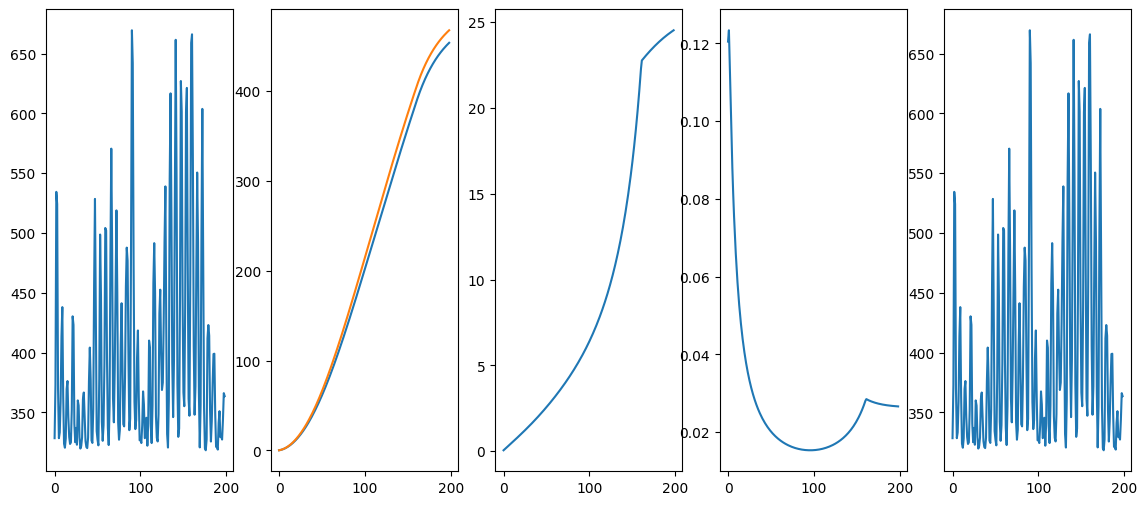

In [19]:
_, (plt1, plt2, plt3, plt4, plt5) = plt.subplots(1,5, figsize=(14, 6))

plt1.plot(loss_)
plt2.plot(huber_loss_)
plt3.plot(huber_loss_weighted)
plt4.plot(imp_weight_)
plt5.plot(model_huber_loss)

In [20]:
from copy import deepcopy
import pickle
import sys

batches_iter = 5000

def train_model(opt_state, params, avg_params, model_name, train_new_model=False, energy_method=False, cont=True):
    best_loss = sys.float_info.max # initialization
        
    if cont:
      params = avg_params = restore(model_paths, model_name)
    if train_new_model or not os.path.exists(osp.join(data_paths, model_name + '_state.pt')):
        key = jax.random.PRNGKey(42)
        subkeys = jax.random.split(key, batches_iter)
        losses = []
        for iteration in range(0, batches_iter):
            data_in_batch, label = next(train)
            data_in_batch = normalize(data_in_batch)
            label_one_hot = jax.nn.one_hot(label, 63)
            idx = jnp.multiply(jax.random.uniform(key=subkeys[iteration], shape=(batch_size, 1)), timesteps-1).astype(int)
            idx = einops.rearrange(idx, 'a b -> (a b)')
            timestep = idx + 1
            data_noisy, noise = get_noisy(data_in_batch, timestep)
            # todo: call gradient update function here
            loss_value, params, opt_state = update(params, opt_state, [data_noisy, label_one_hot, timestep, noise], energy_method)
            avg_params = ema_update(params, avg_params)
            
            if iteration % 10 == 0:                
                ## evaluating noise on a fixed timestep to calculate best model
                one_timestep = jnp.mod(jnp.arange(1, batch_size+1), timesteps)
                data_noisy_temp, noise_temp = get_noisy(data_in_batch, one_timestep)
                loss_temp = jax.device_get(compute_loss(avg_params, [data_noisy_temp, label_one_hot, one_timestep, noise_temp], energy_method))
                losses.append(loss_temp)
                print('batch loss value', loss_value)
            
                if loss_temp < best_loss:
                    best_loss = loss_temp
                    print(f"saving iteration * batch_size: {iteration*batch_size} loss: {best_loss:>7f}")
                    save(model_paths, avg_params, model_name)
                    write_cached([data_noisy, data_in_batch, timestep, losses], osp.join(data_paths, model_name + '_state.pt'))
                    # sample a random number
                    r_ = (jax.random.uniform(subkeys[iteration])*batch_size).astype(int)
                    show_predicted_image(einops.rearrange(data_noisy_temp[r_], 'h w c -> 1 h w c'), avg_params, (r_+1)%timesteps)
            
                if iteration % 100 == 0:
                    print(f"iteration * batch_size: {iteration*batch_size} loss: {loss_temp:>7f}")

    if os.path.exists(osp.join(data_paths, model_name + '_state.pt')):
        avg_params = restore(model_paths, model_name)
        data_noisy, data_in_batch, timestep, losses = load_cached(osp.join(data_paths, model_name + '_state.pt')) 
    return data_noisy, data_in_batch, timestep, losses, avg_params

batch loss value 52989.387
saving iteration * batch_size: 0 loss: 57141.007812
time step for image 53


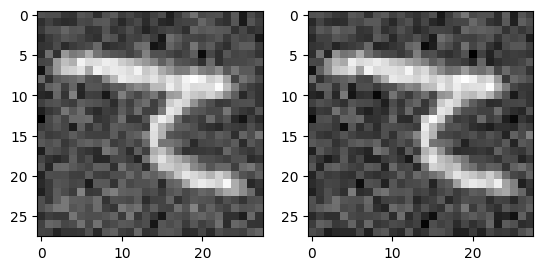

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

iteration * batch_size: 0 loss: 57141.007812
batch loss value 43497.168
saving iteration * batch_size: 1280 loss: 43189.742188
time step for image 39


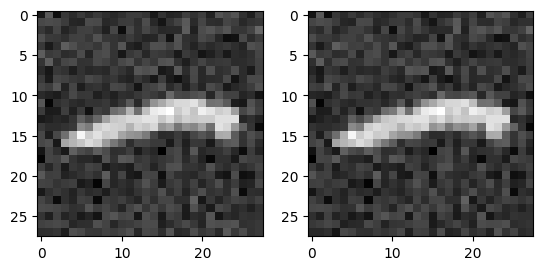

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42927.312
saving iteration * batch_size: 2560 loss: 42885.804688
time step for image 47


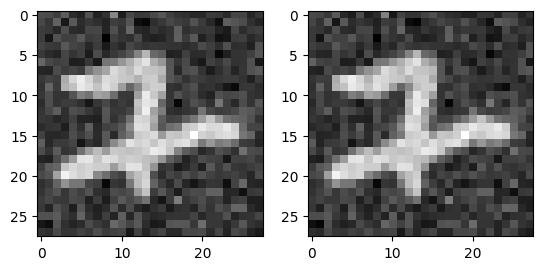

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42746.77
saving iteration * batch_size: 3840 loss: 42764.945312
time step for image 25


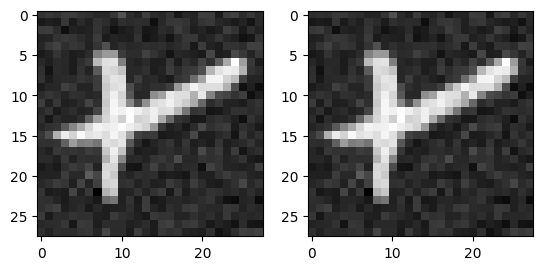

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42724.508
saving iteration * batch_size: 5120 loss: 42722.765625
time step for image 19


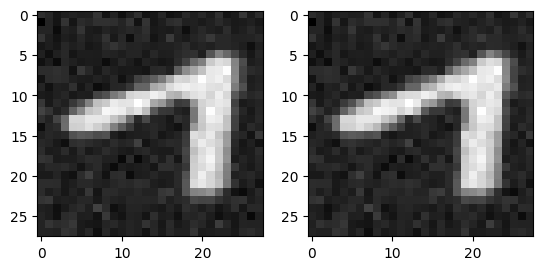

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42695.34
saving iteration * batch_size: 6400 loss: 42690.210938
time step for image 20


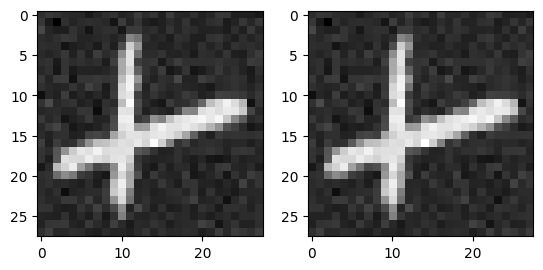

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42662.734
saving iteration * batch_size: 7680 loss: 42668.468750
time step for image 114


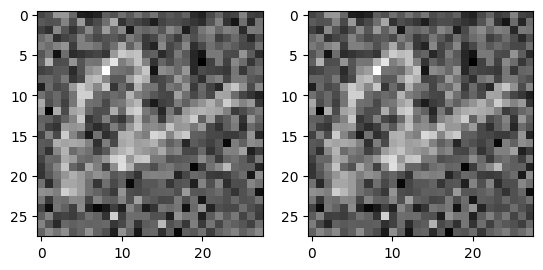

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42677.32
saving iteration * batch_size: 8960 loss: 42657.921875
time step for image 5


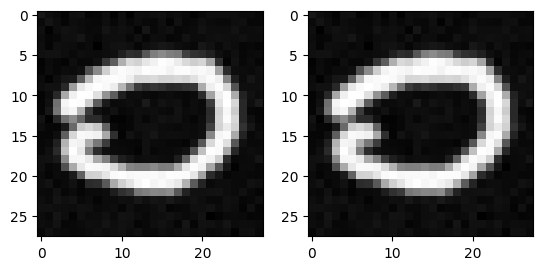

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42657.203
saving iteration * batch_size: 10240 loss: 42646.195312
time step for image 5


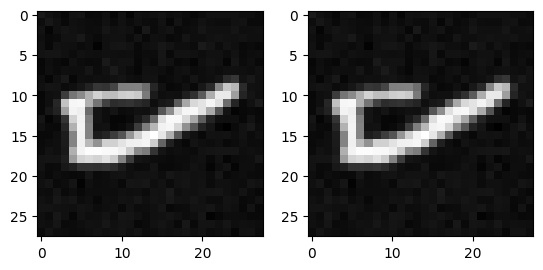

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42627.473
saving iteration * batch_size: 11520 loss: 42634.011719
time step for image 100


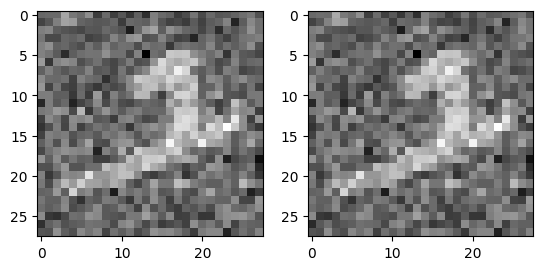

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42638.336
saving iteration * batch_size: 12800 loss: 42629.835938
time step for image 82


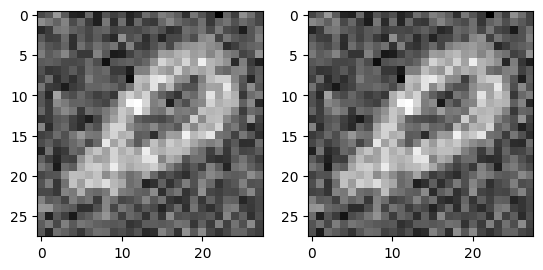

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

iteration * batch_size: 12800 loss: 42629.835938
batch loss value 42620.938
saving iteration * batch_size: 14080 loss: 42622.062500
time step for image 84


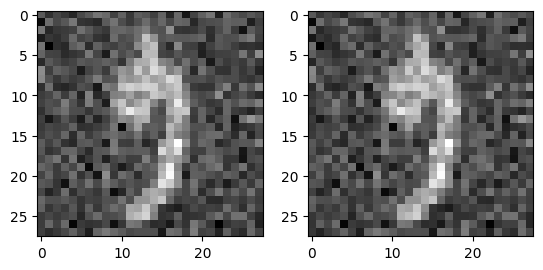

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42611.094
saving iteration * batch_size: 15360 loss: 42612.554688
time step for image 88


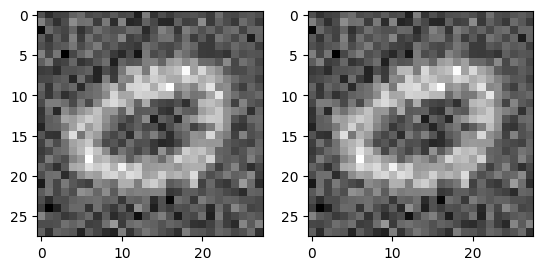

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42601.06
saving iteration * batch_size: 16640 loss: 42604.570312
time step for image 110


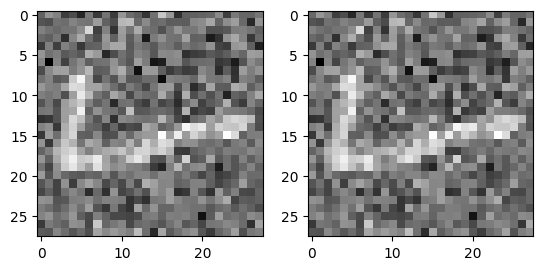

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42603.07
saving iteration * batch_size: 17920 loss: 42598.671875
time step for image 61


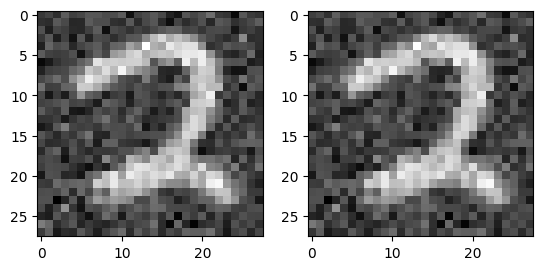

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42599.55
saving iteration * batch_size: 19200 loss: 42598.195312
time step for image 65


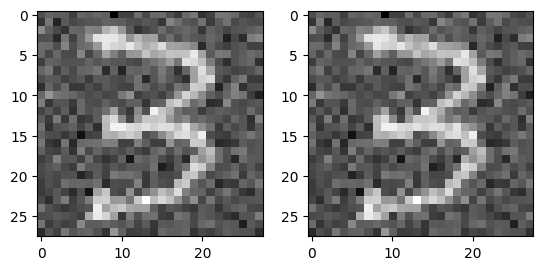

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42596.676
saving iteration * batch_size: 20480 loss: 42593.531250
time step for image 57


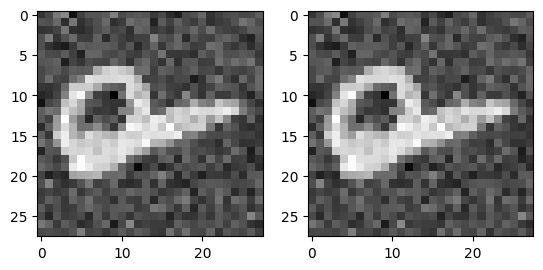

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42591.664
saving iteration * batch_size: 21760 loss: 42591.000000
time step for image 21


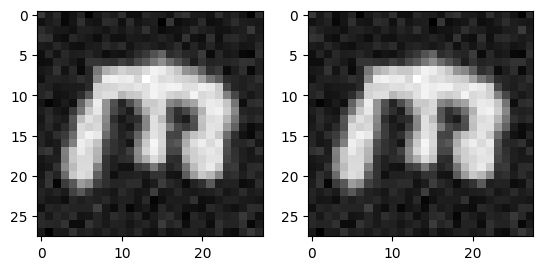

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42603.08
saving iteration * batch_size: 23040 loss: 42586.609375
time step for image 126


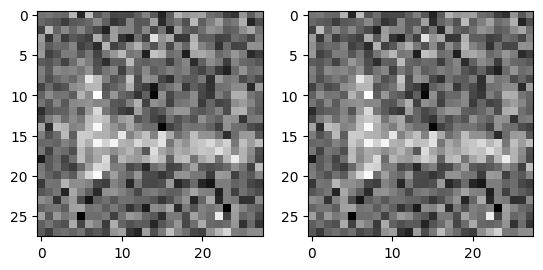

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42592.004
saving iteration * batch_size: 24320 loss: 42586.500000
time step for image 29


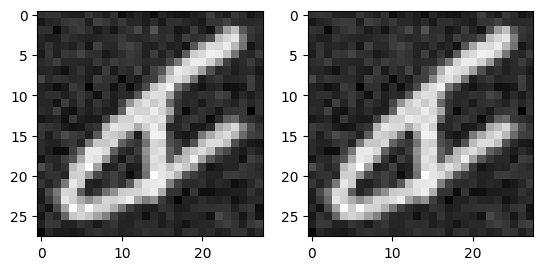

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42601.008
saving iteration * batch_size: 25600 loss: 42578.160156
time step for image 64


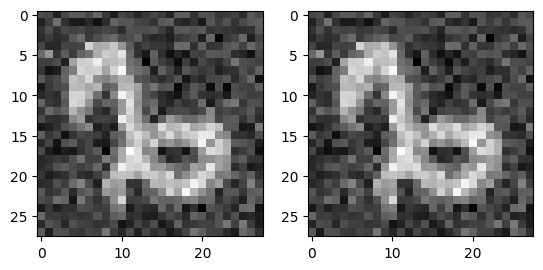

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

iteration * batch_size: 25600 loss: 42578.160156
batch loss value 42572.914
batch loss value 42582.227
saving iteration * batch_size: 28160 loss: 42575.707031
time step for image 43


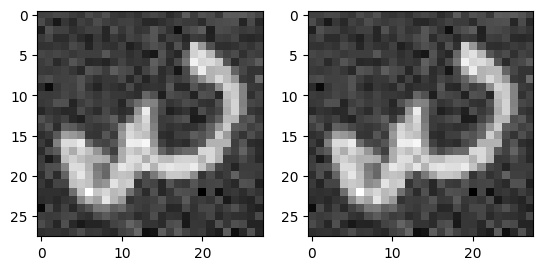

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42579.52
saving iteration * batch_size: 29440 loss: 42569.578125
time step for image 55


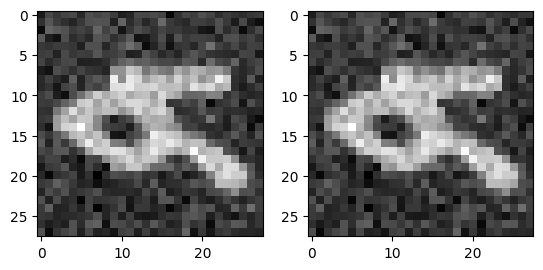

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42580.426
batch loss value 42567.758
batch loss value 42577.516
saving iteration * batch_size: 33280 loss: 42564.257812
time step for image 23


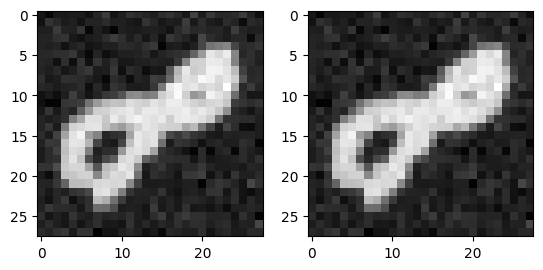

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42567.273
batch loss value 42576.027
saving iteration * batch_size: 35840 loss: 42561.929688
time step for image 86


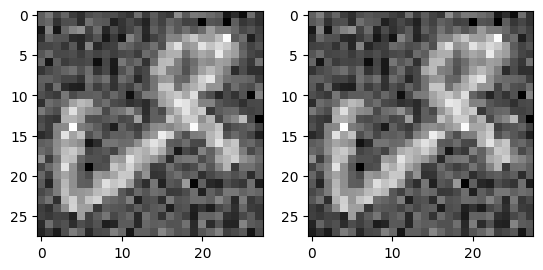

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42564.848
batch loss value 42566.79
saving iteration * batch_size: 38400 loss: 42561.035156
time step for image 55


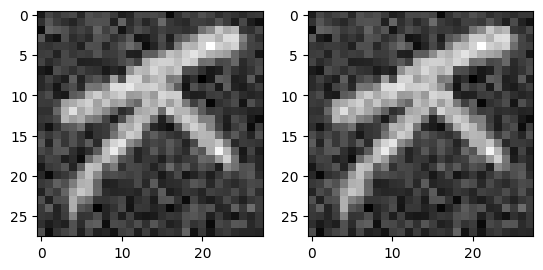

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

iteration * batch_size: 38400 loss: 42561.035156
batch loss value 42565.008
saving iteration * batch_size: 39680 loss: 42557.167969
time step for image 58


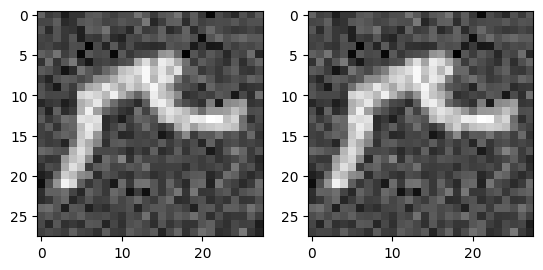

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42566.43
saving iteration * batch_size: 40960 loss: 42556.289062
time step for image 52


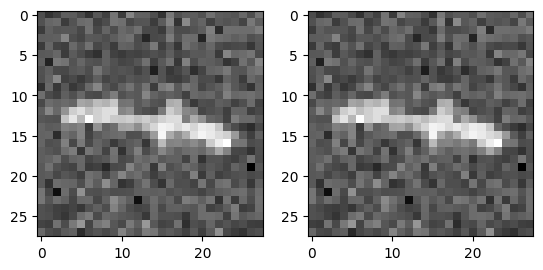

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42561.9
saving iteration * batch_size: 42240 loss: 42549.128906
time step for image 37


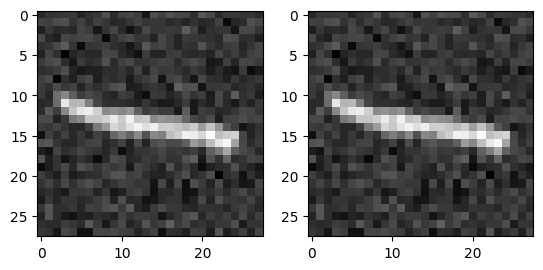

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42559.035
saving iteration * batch_size: 43520 loss: 42548.312500
time step for image 74


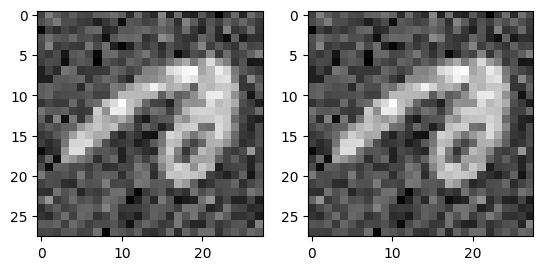

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42548.883
saving iteration * batch_size: 44800 loss: 42545.234375
time step for image 4


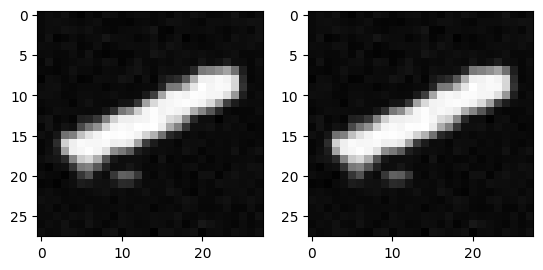

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42555.83
batch loss value 42548.14
batch loss value 42551.723
batch loss value 42542.21
saving iteration * batch_size: 49920 loss: 42544.039062
time step for image 57


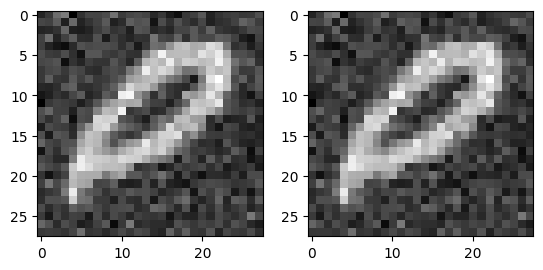

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42525.508
saving iteration * batch_size: 51200 loss: 42527.242188
time step for image 46


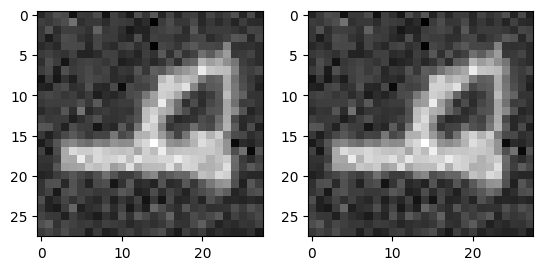

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

iteration * batch_size: 51200 loss: 42527.242188
batch loss value 42525.195
saving iteration * batch_size: 52480 loss: 42522.992188
time step for image 88


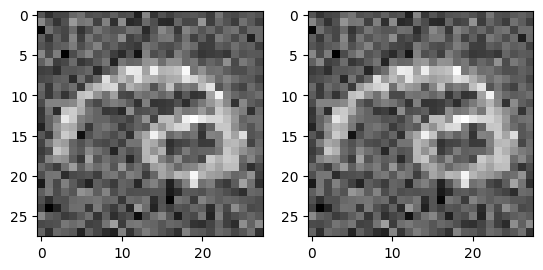

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42504.34
saving iteration * batch_size: 53760 loss: 42509.695312
time step for image 118


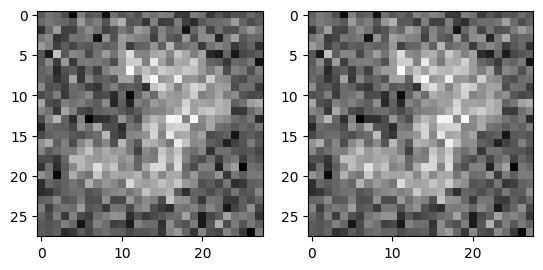

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42482.79
saving iteration * batch_size: 55040 loss: 42501.335938
time step for image 86


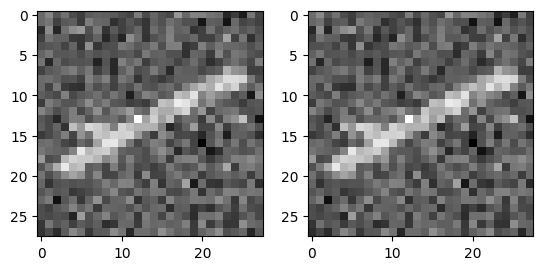

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42445.465
saving iteration * batch_size: 56320 loss: 42459.031250
time step for image 127


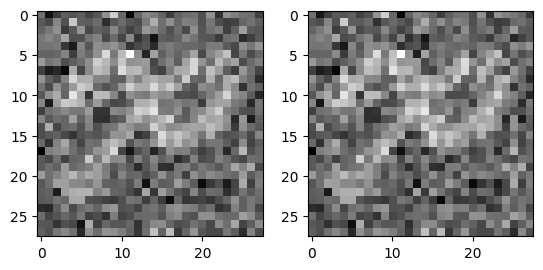

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42430.49
saving iteration * batch_size: 57600 loss: 42438.593750
time step for image 95


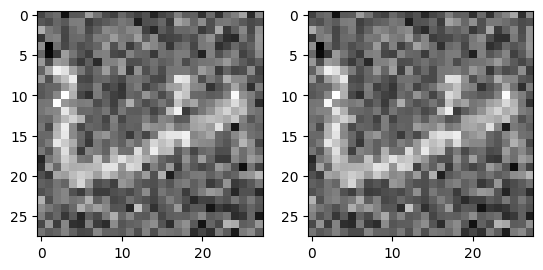

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42373.55
saving iteration * batch_size: 58880 loss: 42407.812500
time step for image 102


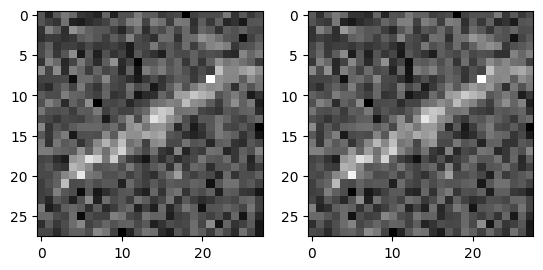

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42274.133
saving iteration * batch_size: 60160 loss: 42337.132812
time step for image 48


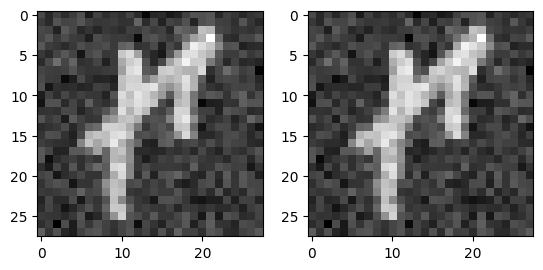

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 42178.477
saving iteration * batch_size: 61440 loss: 42269.093750
time step for image 13


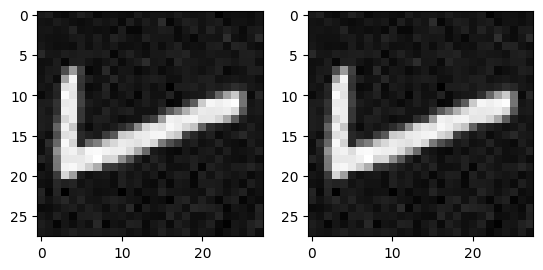

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 41996.918
saving iteration * batch_size: 62720 loss: 42108.492188
time step for image 68


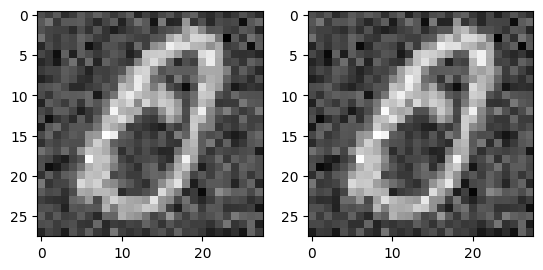

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 41798.3
saving iteration * batch_size: 64000 loss: 41999.421875
time step for image 58


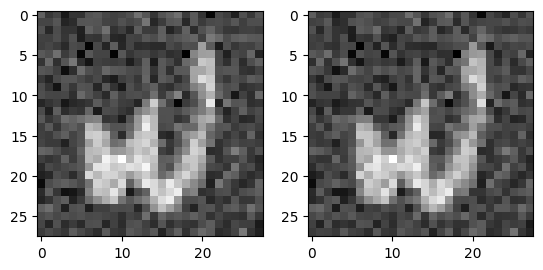

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

iteration * batch_size: 64000 loss: 41999.421875
batch loss value 41622.703
saving iteration * batch_size: 65280 loss: 41806.773438
time step for image 82


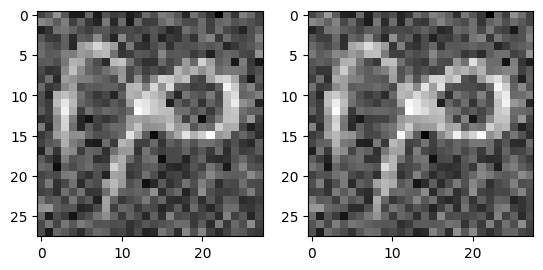

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 41278.28
saving iteration * batch_size: 66560 loss: 41585.703125
time step for image 19


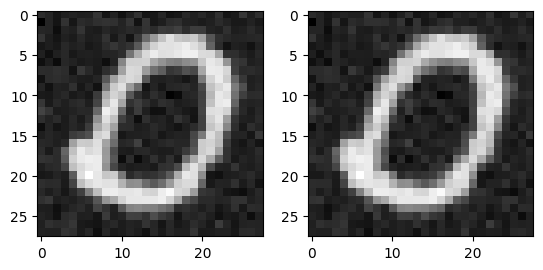

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 41002.234
saving iteration * batch_size: 67840 loss: 41351.218750
time step for image 46


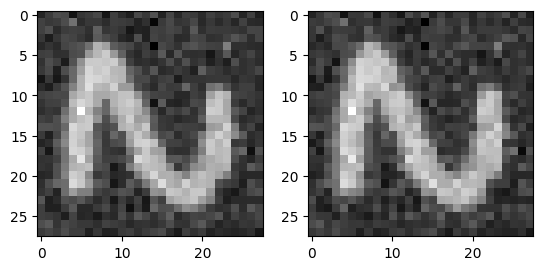

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 40633.68
saving iteration * batch_size: 69120 loss: 41043.675781
time step for image 49


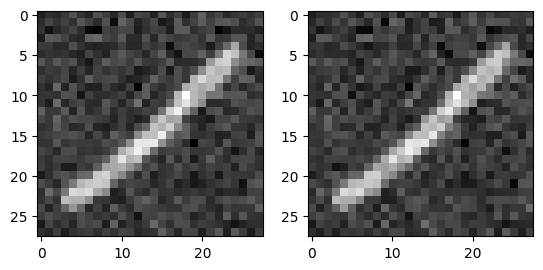

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 40269.496
saving iteration * batch_size: 70400 loss: 40749.324219
time step for image 53


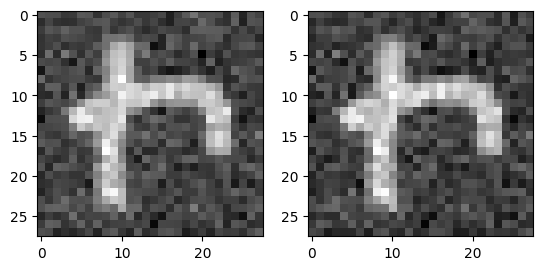

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 40016.86
saving iteration * batch_size: 71680 loss: 40377.453125
time step for image 37


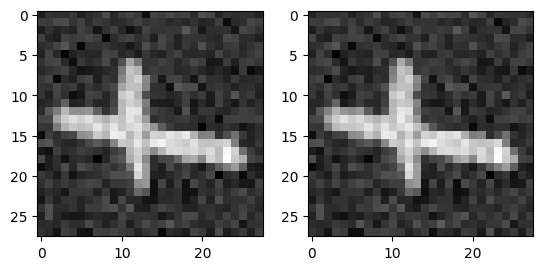

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 39671.793
saving iteration * batch_size: 72960 loss: 39989.140625
time step for image 64


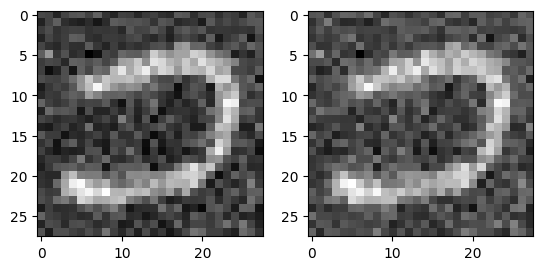

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 39148.54
saving iteration * batch_size: 74240 loss: 39662.523438
time step for image 22


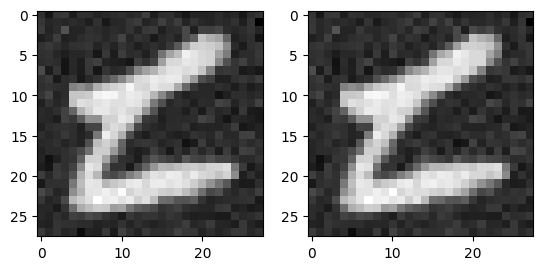

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 38751.37
saving iteration * batch_size: 75520 loss: 39482.960938
time step for image 120


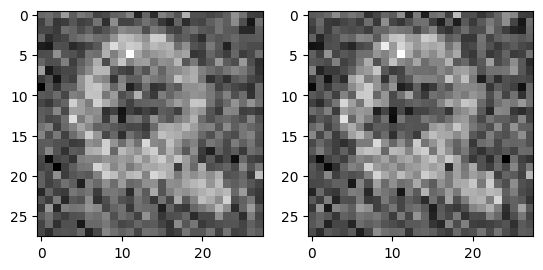

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 38459.72
saving iteration * batch_size: 76800 loss: 39055.742188
time step for image 46


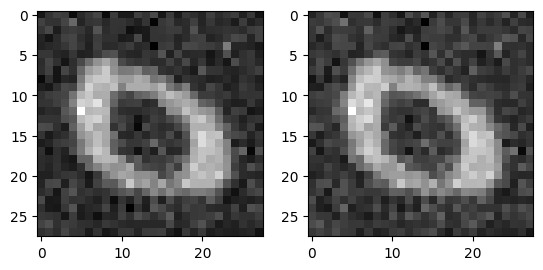

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

iteration * batch_size: 76800 loss: 39055.742188
batch loss value 37592.22
saving iteration * batch_size: 78080 loss: 38527.960938
time step for image 99


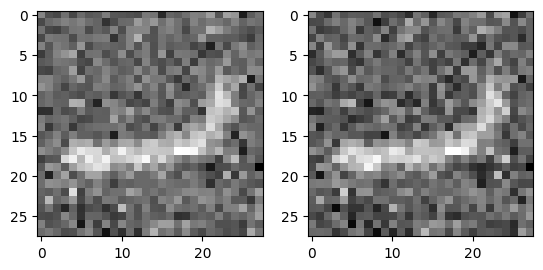

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 37846.734
saving iteration * batch_size: 79360 loss: 38170.000000
time step for image 113


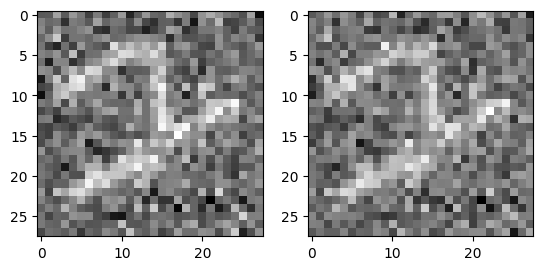

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 37110.773
saving iteration * batch_size: 80640 loss: 37892.824219
time step for image 72


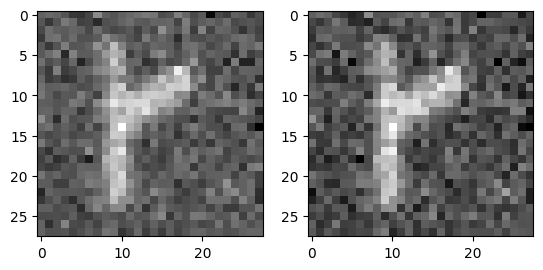

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 37015.65
saving iteration * batch_size: 81920 loss: 37650.031250
time step for image 4


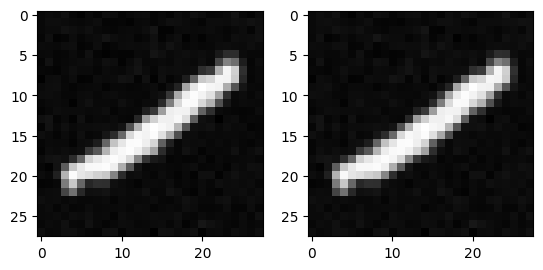

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 36288.234
saving iteration * batch_size: 83200 loss: 37224.343750
time step for image 119


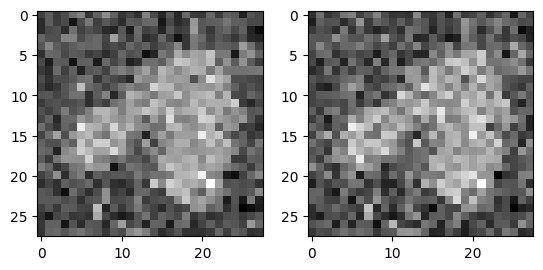

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 35771.098
saving iteration * batch_size: 84480 loss: 36947.230469
time step for image 50


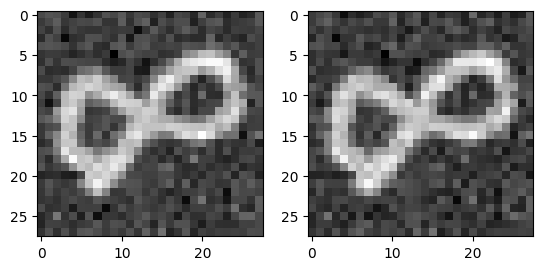

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 35730.504
saving iteration * batch_size: 85760 loss: 36641.515625
time step for image 87


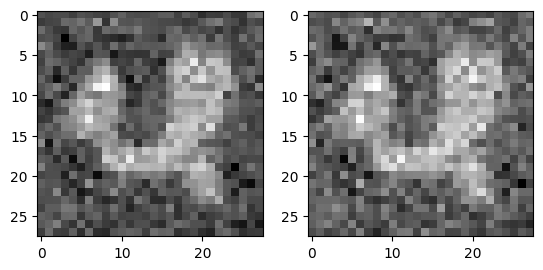

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 35226.57
saving iteration * batch_size: 87040 loss: 36445.722656
time step for image 123


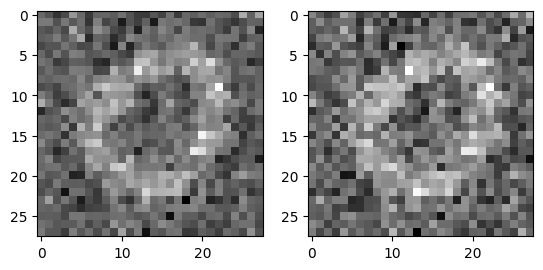

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 34981.086
saving iteration * batch_size: 88320 loss: 35997.660156
time step for image 72


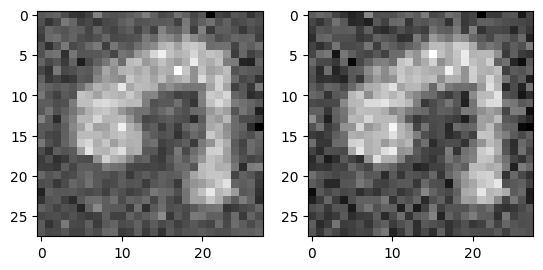

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 34927.035
saving iteration * batch_size: 89600 loss: 35763.984375
time step for image 5


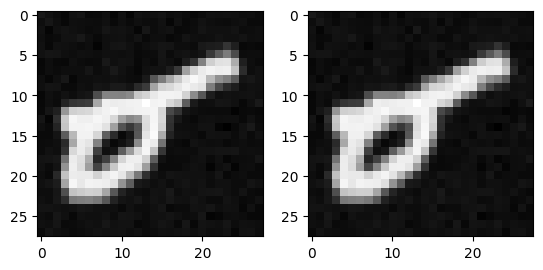

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

iteration * batch_size: 89600 loss: 35763.984375
batch loss value 34542.207
saving iteration * batch_size: 90880 loss: 35634.296875
time step for image 41


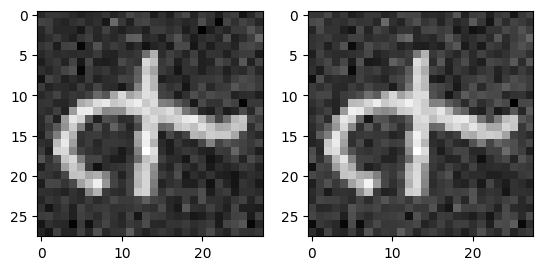

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 34287.18
saving iteration * batch_size: 92160 loss: 35120.609375
time step for image 62


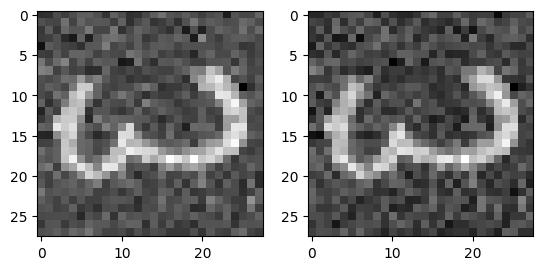

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 33525.47
saving iteration * batch_size: 93440 loss: 34935.484375
time step for image 120


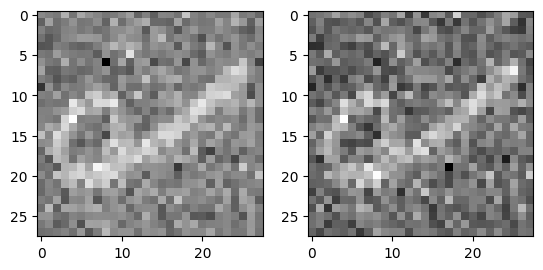

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 33597.15
saving iteration * batch_size: 94720 loss: 34506.945312
time step for image 45


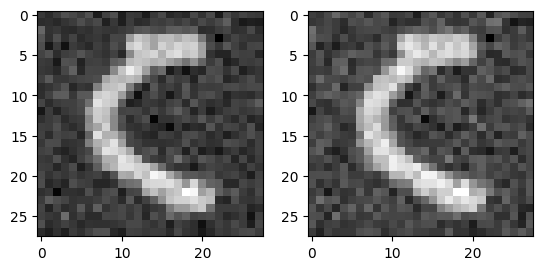

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 33275.273
saving iteration * batch_size: 96000 loss: 34487.640625
time step for image 62


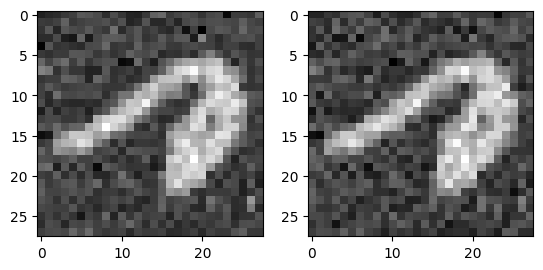

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 33049.492
saving iteration * batch_size: 97280 loss: 34220.355469
time step for image 90


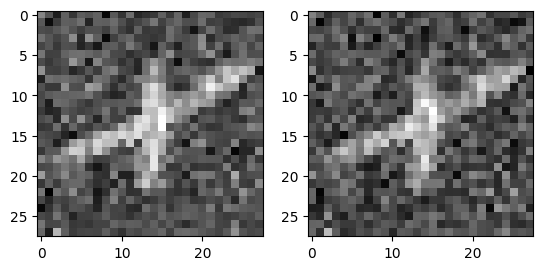

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 32656.146
saving iteration * batch_size: 98560 loss: 34049.523438
time step for image 41


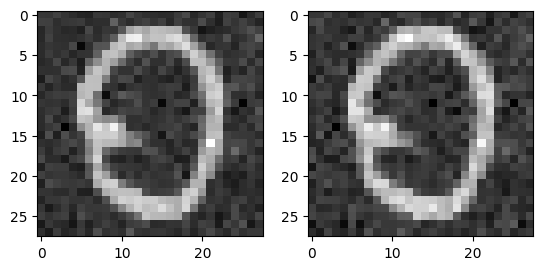

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 32523.19
saving iteration * batch_size: 99840 loss: 33931.601562
time step for image 30


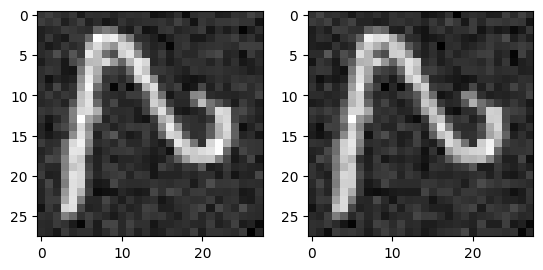

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 32704.074
saving iteration * batch_size: 101120 loss: 33567.492188
time step for image 51


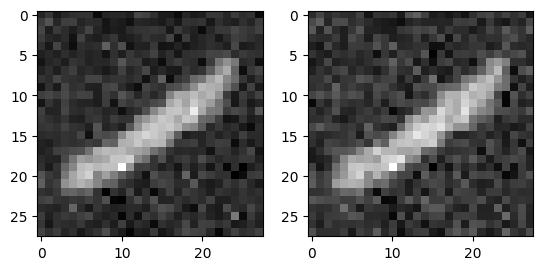

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 32543.102
saving iteration * batch_size: 102400 loss: 33447.222656
time step for image 98


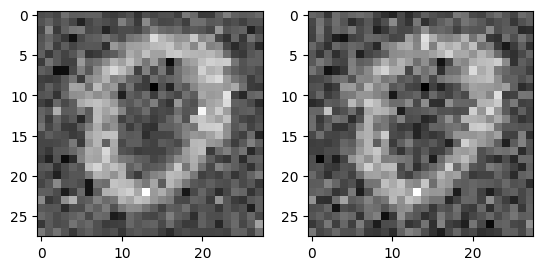

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

iteration * batch_size: 102400 loss: 33447.222656
batch loss value 31742.248
saving iteration * batch_size: 103680 loss: 33172.902344
time step for image 124


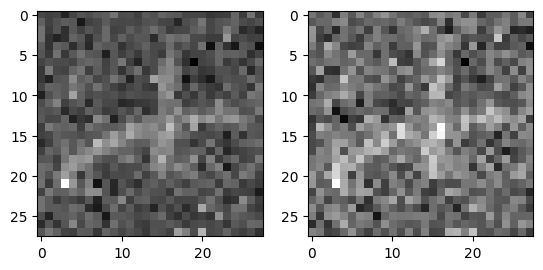

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 31995.691
saving iteration * batch_size: 104960 loss: 32920.855469
time step for image 122


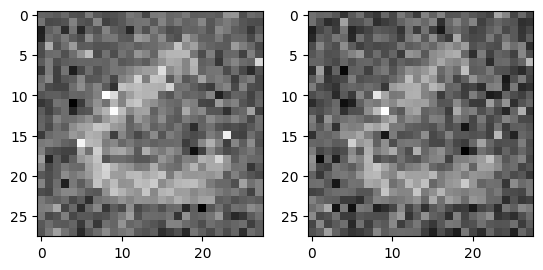

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 31037.434
saving iteration * batch_size: 106240 loss: 32851.703125
time step for image 26


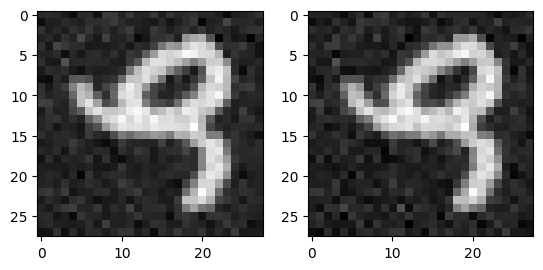

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 32292.44
saving iteration * batch_size: 107520 loss: 32834.500000
time step for image 21


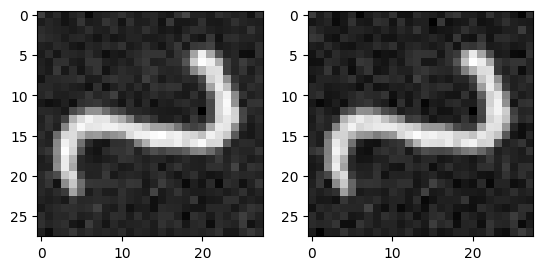

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 31058.303
saving iteration * batch_size: 108800 loss: 32592.261719
time step for image 44


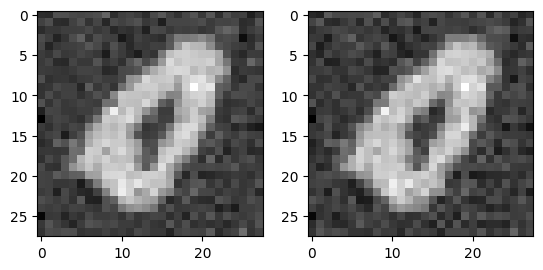

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 31707.95
batch loss value 31009.434
saving iteration * batch_size: 111360 loss: 32378.353516
time step for image 47


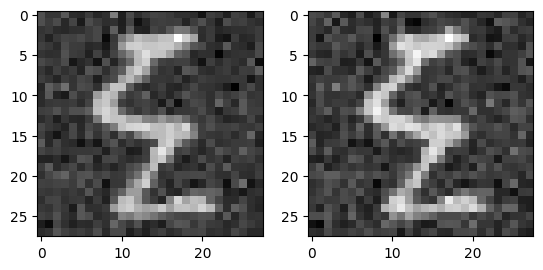

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 30845.852
saving iteration * batch_size: 112640 loss: 32245.300781
time step for image 85


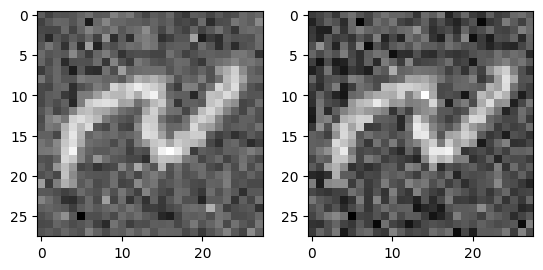

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 31120.385
saving iteration * batch_size: 113920 loss: 32048.525391
time step for image 8


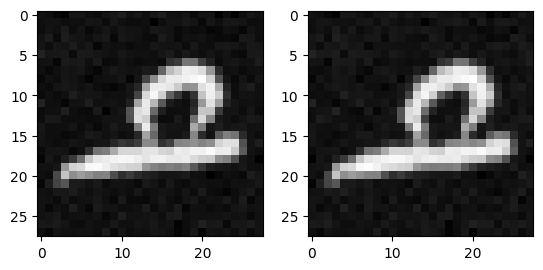

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 30045.75
saving iteration * batch_size: 115200 loss: 31795.951172
time step for image 15


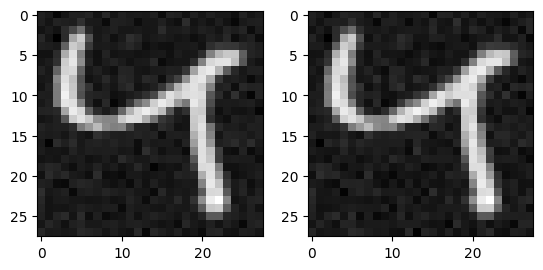

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

iteration * batch_size: 115200 loss: 31795.951172
batch loss value 30958.549
batch loss value 29820.855
saving iteration * batch_size: 117760 loss: 31651.107422
time step for image 22


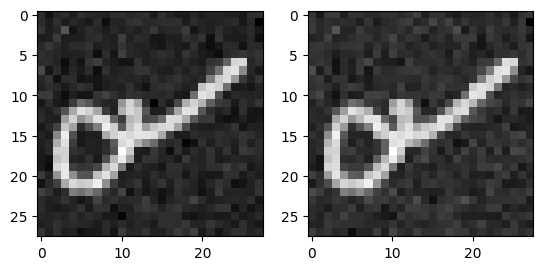

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 29925.994
saving iteration * batch_size: 119040 loss: 31581.326172
time step for image 5


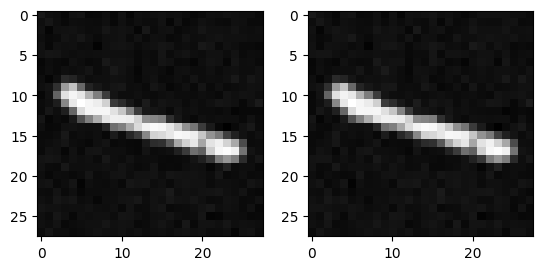

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 29860.836
saving iteration * batch_size: 120320 loss: 31422.705078
time step for image 25


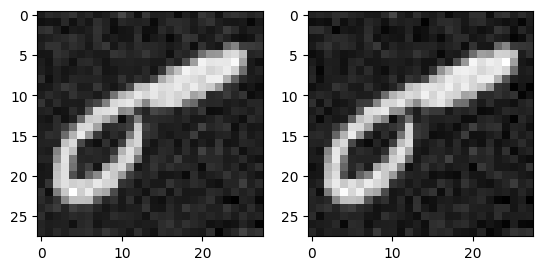

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 29289.637
saving iteration * batch_size: 121600 loss: 30899.925781
time step for image 30


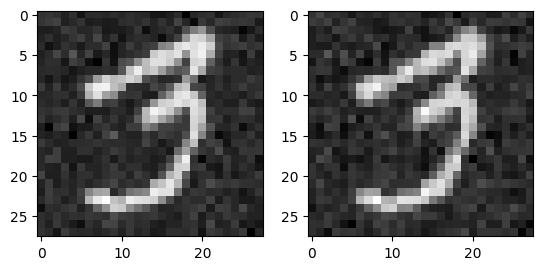

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 29249.11
batch loss value 29470.123
saving iteration * batch_size: 124160 loss: 30585.105469
time step for image 113


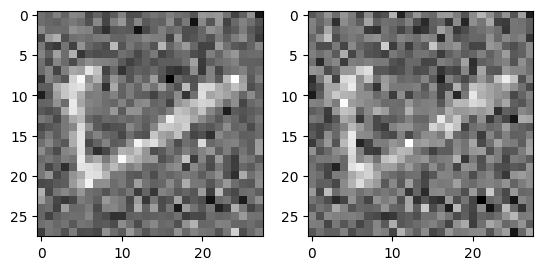

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 29658.523
batch loss value 28746.027
batch loss value 29608.645
iteration * batch_size: 128000 loss: 30675.080078
batch loss value 28707.588
saving iteration * batch_size: 129280 loss: 30410.742188
time step for image 90


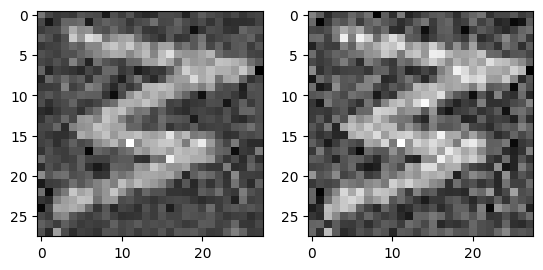

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 28614.965
batch loss value 28183.277
batch loss value 29490.238
saving iteration * batch_size: 133120 loss: 30337.935547
time step for image 77


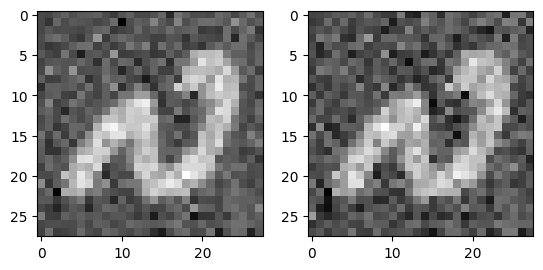

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 28067.18
saving iteration * batch_size: 134400 loss: 30008.962891
time step for image 110


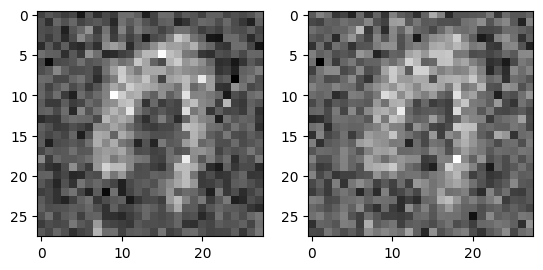

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 28535.871
saving iteration * batch_size: 135680 loss: 29703.355469
time step for image 52


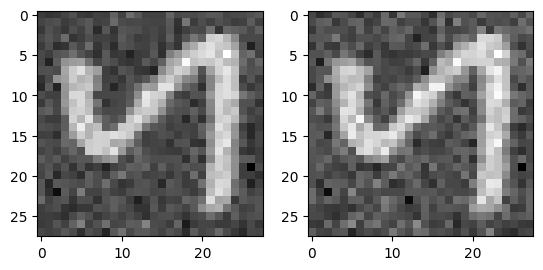

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 28100.926
batch loss value 28451.092
batch loss value 28184.723
saving iteration * batch_size: 139520 loss: 29658.972656
time step for image 54


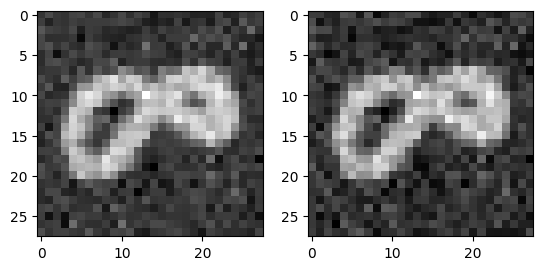

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 27711.027
saving iteration * batch_size: 140800 loss: 29628.269531
time step for image 112


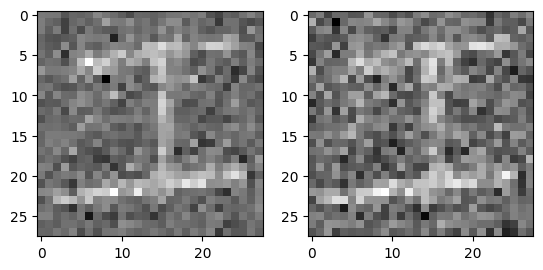

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

iteration * batch_size: 140800 loss: 29628.269531
batch loss value 28489.557
batch loss value 28492.156
batch loss value 27344.148
saving iteration * batch_size: 144640 loss: 29342.410156
time step for image 8


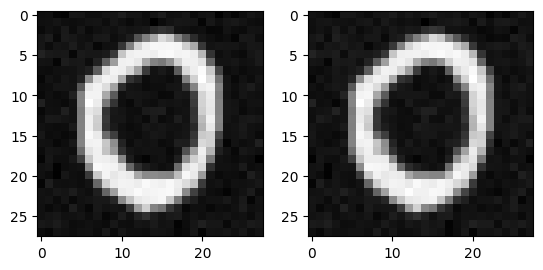

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 27899.578
batch loss value 27602.643
saving iteration * batch_size: 147200 loss: 29172.117188
time step for image 71


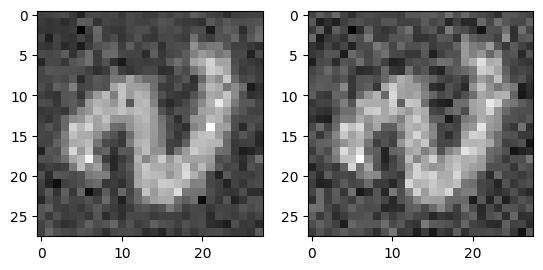

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 27858.947
saving iteration * batch_size: 148480 loss: 28941.117188
time step for image 125


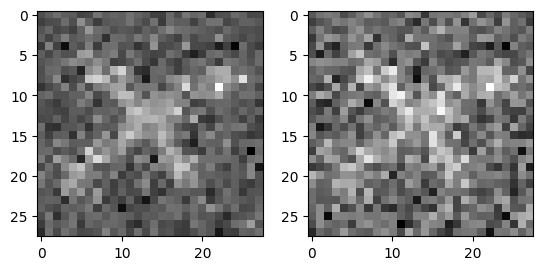

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 27303.047
saving iteration * batch_size: 149760 loss: 28902.433594
time step for image 118


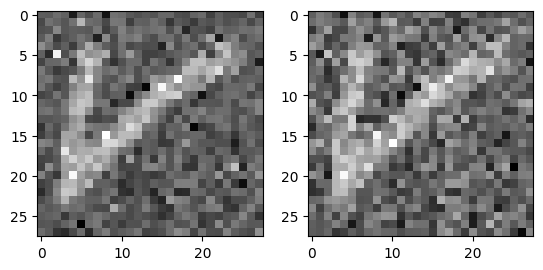

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 26890.008
batch loss value 27545.719
saving iteration * batch_size: 152320 loss: 28678.058594
time step for image 6


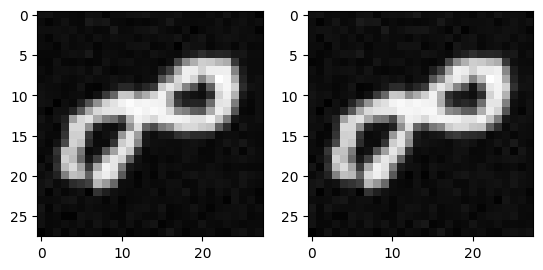

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 27999.113
iteration * batch_size: 153600 loss: 28898.128906
batch loss value 27496.625
batch loss value 27509.803
batch loss value 25955.73
saving iteration * batch_size: 157440 loss: 28136.433594
time step for image 43


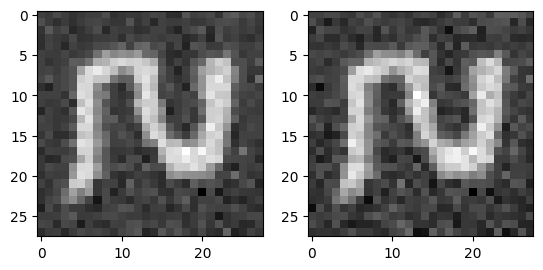

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 27975.6
batch loss value 26539.27
batch loss value 26745.775
batch loss value 26724.395
batch loss value 26972.37
batch loss value 27066.21
batch loss value 26120.691
saving iteration * batch_size: 166400 loss: 27833.347656
time step for image 21


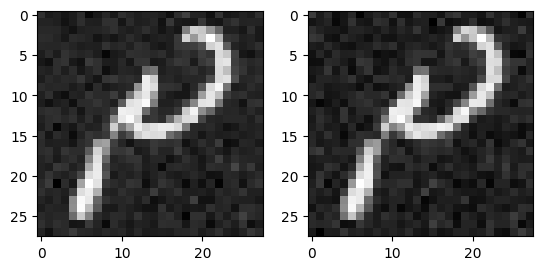

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

iteration * batch_size: 166400 loss: 27833.347656
batch loss value 26895.578
batch loss value 26253.902
batch loss value 27302.43
batch loss value 25722.734
saving iteration * batch_size: 171520 loss: 27706.416016
time step for image 38


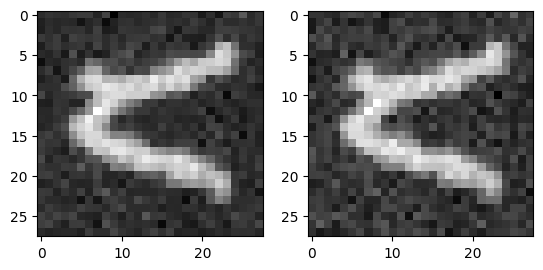

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 26451.22
saving iteration * batch_size: 172800 loss: 27668.757812
time step for image 40


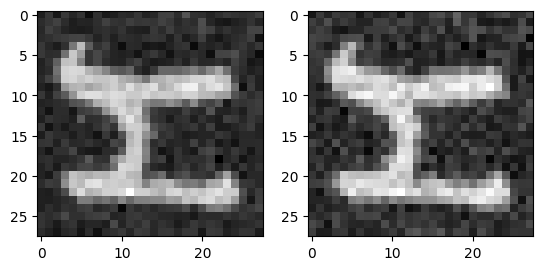

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 27032.047
batch loss value 26046.32
saving iteration * batch_size: 175360 loss: 27599.382812
time step for image 24


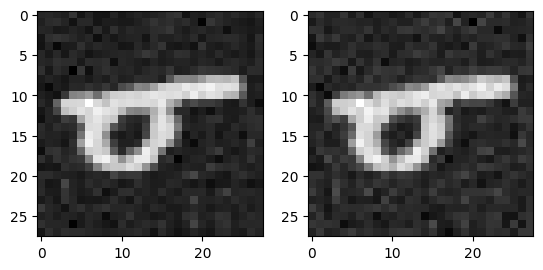

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 26652.688
batch loss value 25867.367
batch loss value 25937.553
saving iteration * batch_size: 179200 loss: 27564.515625
time step for image 84


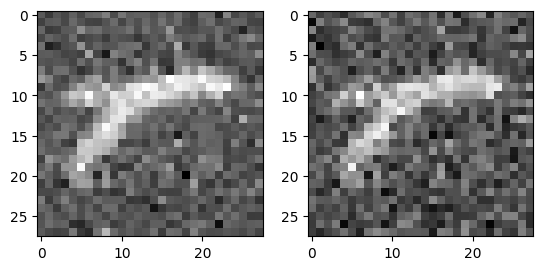

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

iteration * batch_size: 179200 loss: 27564.515625
batch loss value 25911.01
batch loss value 26158.0
saving iteration * batch_size: 181760 loss: 27462.708984
time step for image 84


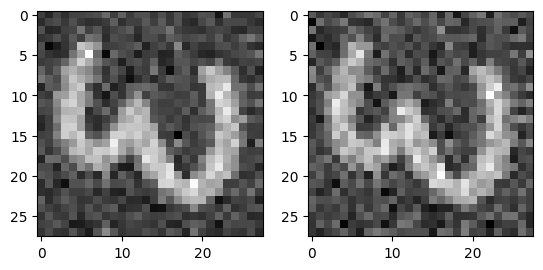

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 25904.92
saving iteration * batch_size: 183040 loss: 27037.886719
time step for image 9


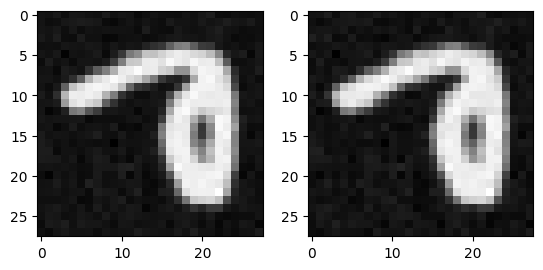

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 26282.6
batch loss value 25876.059
batch loss value 25525.123
batch loss value 24888.25
batch loss value 24835.752
saving iteration * batch_size: 189440 loss: 26645.750000
time step for image 79


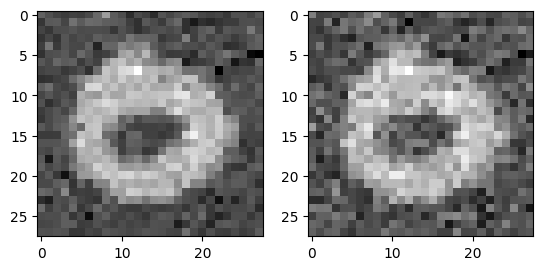

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 25068.455
batch loss value 25154.375
iteration * batch_size: 192000 loss: 26965.746094
batch loss value 25260.809
batch loss value 25441.236
batch loss value 25445.812
batch loss value 25157.543
batch loss value 25227.176
batch loss value 25260.578
batch loss value 25488.402
saving iteration * batch_size: 200960 loss: 26580.417969
time step for image 111


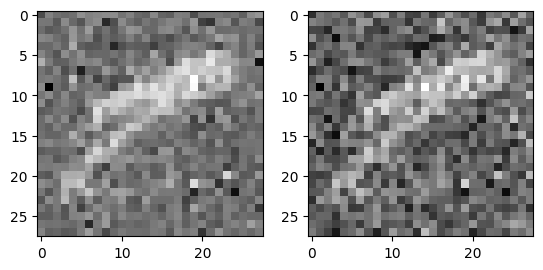

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 25600.953
batch loss value 24508.219
saving iteration * batch_size: 203520 loss: 26508.189453
time step for image 106


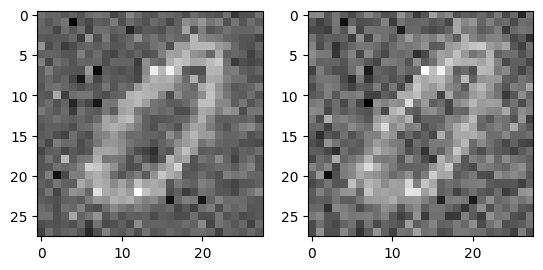

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 25128.918
iteration * batch_size: 204800 loss: 26565.257812
batch loss value 25586.2
batch loss value 24443.703
batch loss value 24398.398
batch loss value 24559.42
batch loss value 24972.96
saving iteration * batch_size: 211200 loss: 26186.070312
time step for image 65


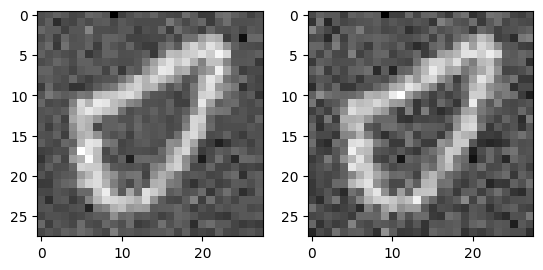

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 24424.797
batch loss value 24785.988
batch loss value 24835.465
batch loss value 25172.102
saving iteration * batch_size: 216320 loss: 26112.230469
time step for image 60


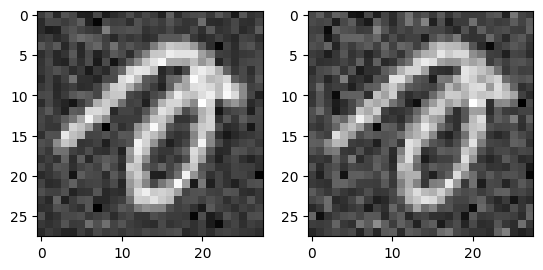

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 24106.809
saving iteration * batch_size: 217600 loss: 25946.906250
time step for image 61


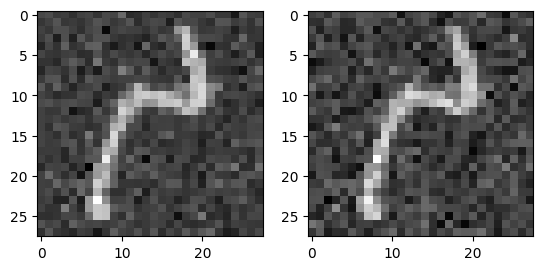

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

iteration * batch_size: 217600 loss: 25946.906250
batch loss value 24258.941
batch loss value 24244.08
batch loss value 24681.447
batch loss value 24211.559
saving iteration * batch_size: 222720 loss: 25870.501953
time step for image 73


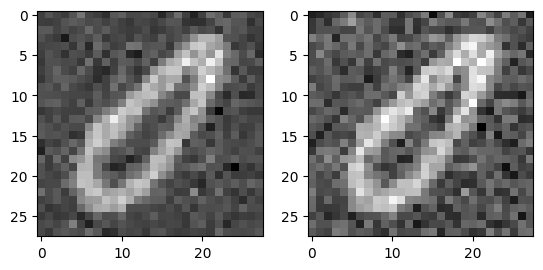

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 24310.96
batch loss value 24175.355
saving iteration * batch_size: 225280 loss: 25833.980469
time step for image 94


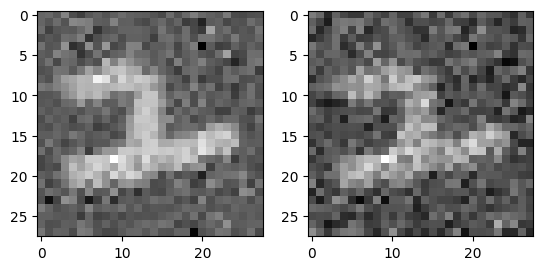

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 24898.992
saving iteration * batch_size: 226560 loss: 25734.386719
time step for image 9


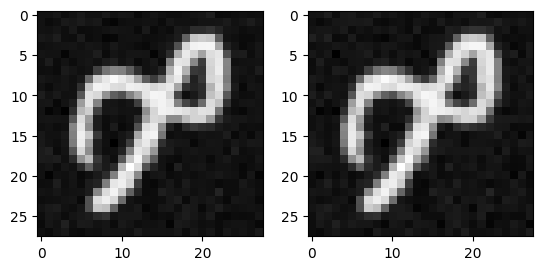

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 24387.316
batch loss value 24199.299
saving iteration * batch_size: 229120 loss: 25702.351562
time step for image 58


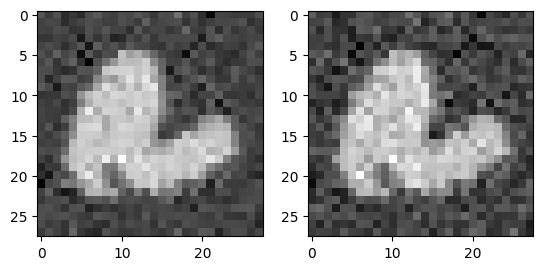

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 24785.516
iteration * batch_size: 230400 loss: 25753.904297
batch loss value 23314.7
saving iteration * batch_size: 231680 loss: 25690.109375
time step for image 118


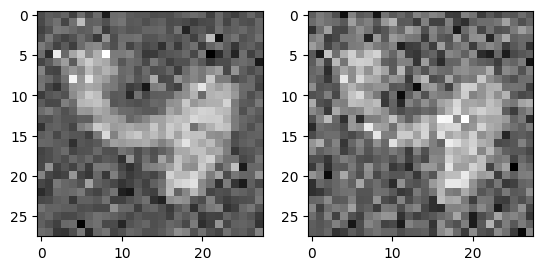

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 23917.203
saving iteration * batch_size: 232960 loss: 25454.308594
time step for image 94


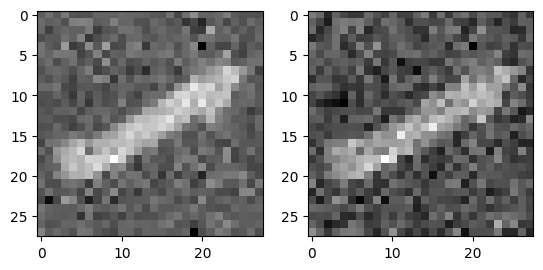

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 23648.828
saving iteration * batch_size: 234240 loss: 25418.652344
time step for image 26


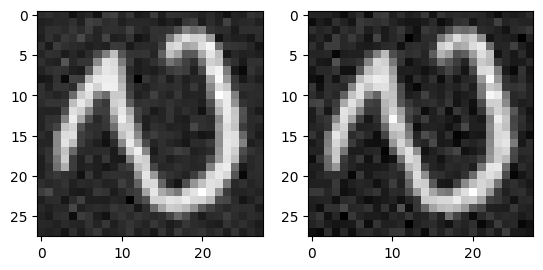

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 23734.158
batch loss value 24079.936
batch loss value 23711.129
batch loss value 24060.324
batch loss value 23700.145
saving iteration * batch_size: 240640 loss: 25284.638672
time step for image 101


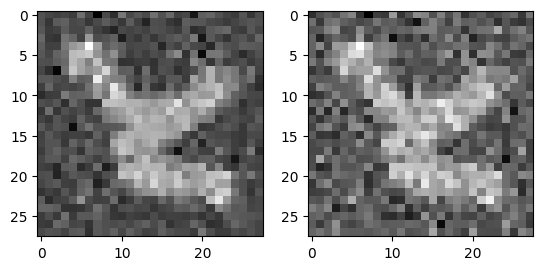

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 24543.96
batch loss value 23465.645
iteration * batch_size: 243200 loss: 25303.140625
batch loss value 23558.016
saving iteration * batch_size: 244480 loss: 25207.205078
time step for image 116


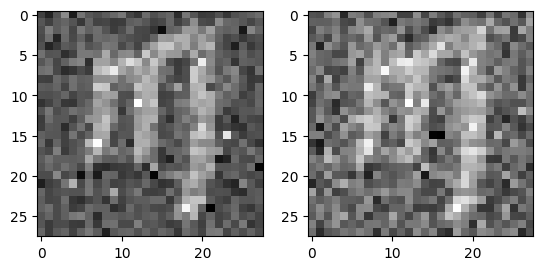

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 24812.535
batch loss value 23546.957
batch loss value 24158.664
batch loss value 23375.824
batch loss value 24010.422
saving iteration * batch_size: 250880 loss: 25006.111328
time step for image 57


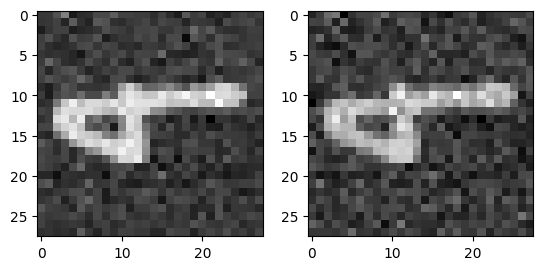

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 23846.357
batch loss value 23510.16
batch loss value 23820.773
batch loss value 23236.877
saving iteration * batch_size: 256000 loss: 24858.832031
time step for image 58


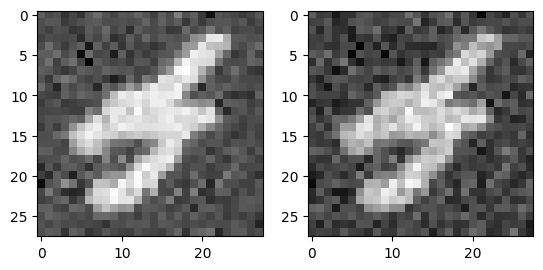

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

iteration * batch_size: 256000 loss: 24858.832031
batch loss value 22788.766
batch loss value 23777.688
saving iteration * batch_size: 258560 loss: 24802.900391
time step for image 76


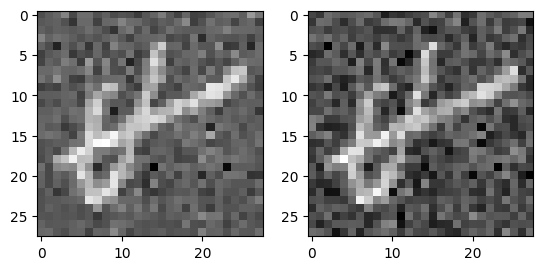

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 23506.938
batch loss value 23407.838
batch loss value 23996.355
batch loss value 23772.86
batch loss value 23479.021
batch loss value 23358.219
batch loss value 22758.014
batch loss value 23320.99
saving iteration * batch_size: 268800 loss: 24798.966797
time step for image 67


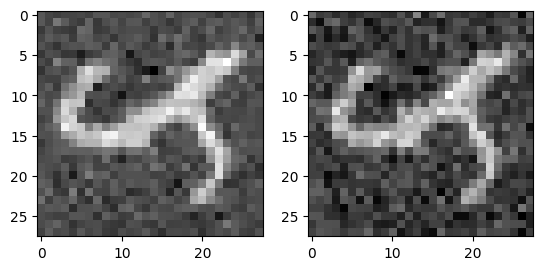

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

iteration * batch_size: 268800 loss: 24798.966797
batch loss value 22830.312
batch loss value 23972.66
batch loss value 22592.615
saving iteration * batch_size: 272640 loss: 24520.839844
time step for image 57


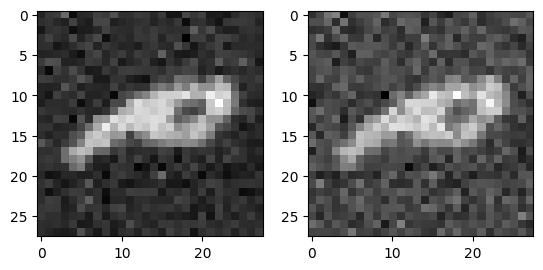

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 23415.297
batch loss value 23054.037
batch loss value 23437.879
saving iteration * batch_size: 276480 loss: 24509.027344
time step for image 112


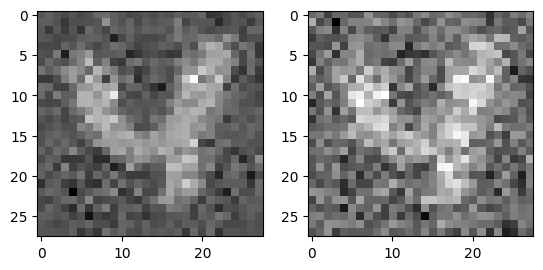

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 23203.48
saving iteration * batch_size: 277760 loss: 24491.222656
time step for image 79


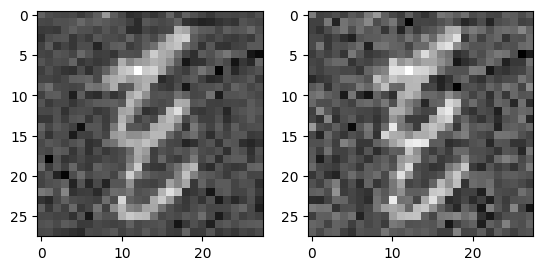

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 22871.408
saving iteration * batch_size: 279040 loss: 24464.597656
time step for image 94


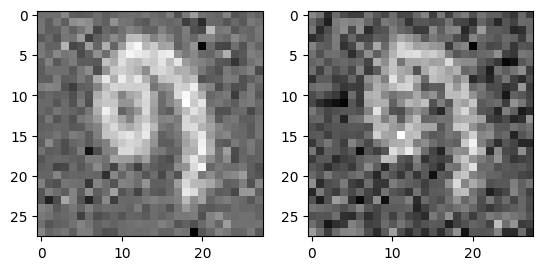

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 23436.963
batch loss value 23132.031
iteration * batch_size: 281600 loss: 24657.152344
batch loss value 23050.54
saving iteration * batch_size: 282880 loss: 24319.490234
time step for image 118


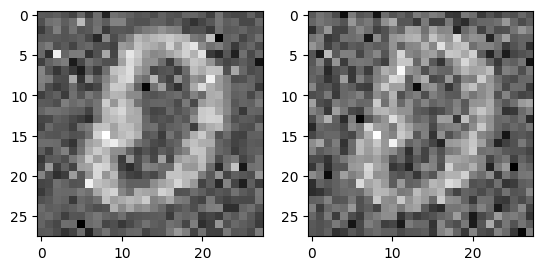

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 22912.566
saving iteration * batch_size: 284160 loss: 24276.126953
time step for image 102


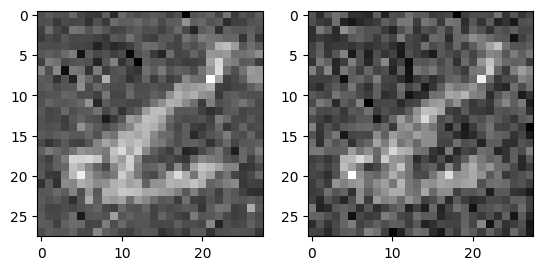

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 23359.383
batch loss value 23913.688
batch loss value 23017.533
saving iteration * batch_size: 288000 loss: 24252.503906
time step for image 9


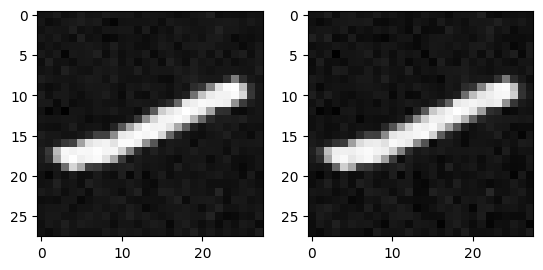

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 23331.502
batch loss value 22422.645
saving iteration * batch_size: 290560 loss: 24121.052734
time step for image 70


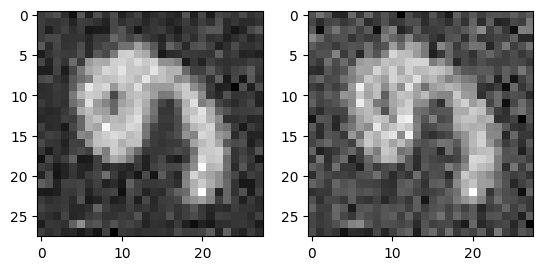

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 23226.973
saving iteration * batch_size: 291840 loss: 23891.751953
time step for image 109


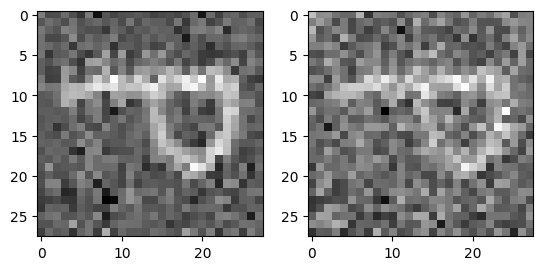

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 22461.059
batch loss value 22994.922
iteration * batch_size: 294400 loss: 24500.898438
batch loss value 22940.309
batch loss value 22908.62
batch loss value 23183.414
batch loss value 23249.857
batch loss value 21702.338
batch loss value 22793.8
batch loss value 23081.754
batch loss value 22904.727
batch loss value 22455.422
batch loss value 22696.895
iteration * batch_size: 307200 loss: 24219.816406
batch loss value 22836.031
batch loss value 23270.33
batch loss value 23279.328
batch loss value 22950.344
batch loss value 22447.357
batch loss value 22496.035
batch loss value 22721.59
saving iteration * batch_size: 316160 loss: 23863.339844
time step for image 7


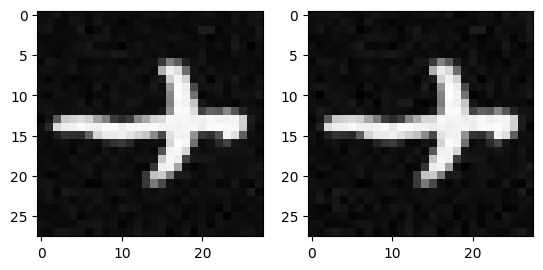

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 22242.55
saving iteration * batch_size: 317440 loss: 23792.042969
time step for image 84


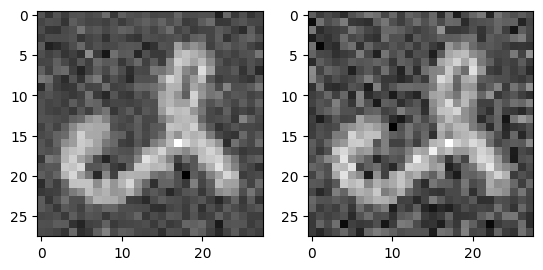

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 22776.988
saving iteration * batch_size: 318720 loss: 23693.347656
time step for image 25


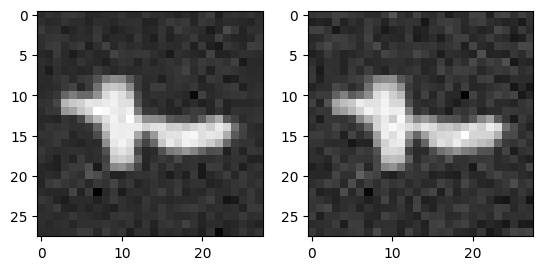

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 22288.78
iteration * batch_size: 320000 loss: 24010.664062
batch loss value 22063.355
batch loss value 22044.371
batch loss value 21454.049
batch loss value 21988.361
saving iteration * batch_size: 325120 loss: 23646.476562
time step for image 39


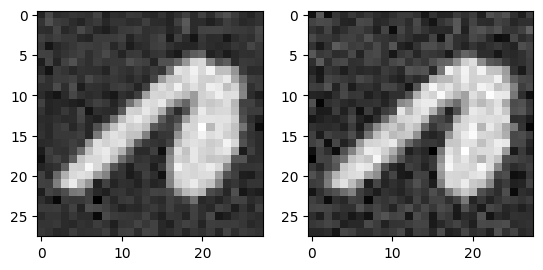

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 22239.625
batch loss value 21716.54
saving iteration * batch_size: 327680 loss: 23613.710938
time step for image 125


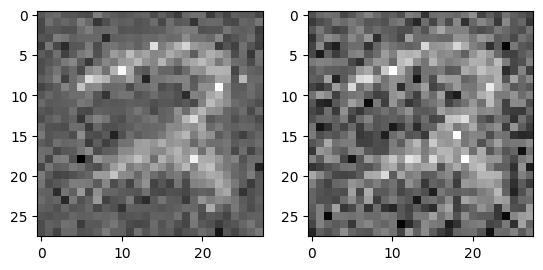

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 22790.496
saving iteration * batch_size: 328960 loss: 23521.847656
time step for image 60


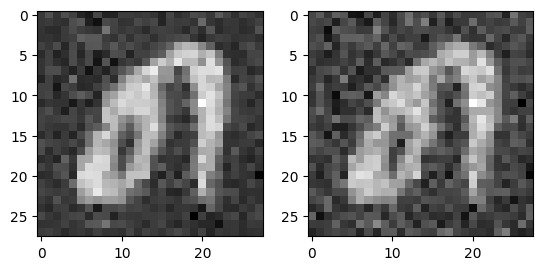

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 22149.18
saving iteration * batch_size: 330240 loss: 23333.794922
time step for image 19


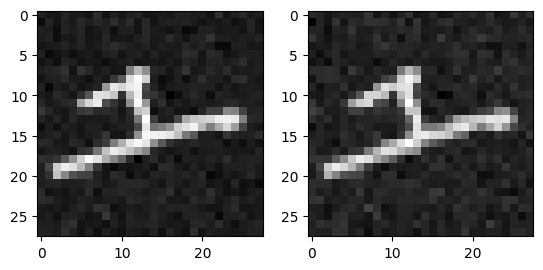

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 21729.879
batch loss value 21659.54
iteration * batch_size: 332800 loss: 23956.039062
batch loss value 21912.71
batch loss value 22105.824
batch loss value 20990.71
saving iteration * batch_size: 336640 loss: 23039.730469
time step for image 57


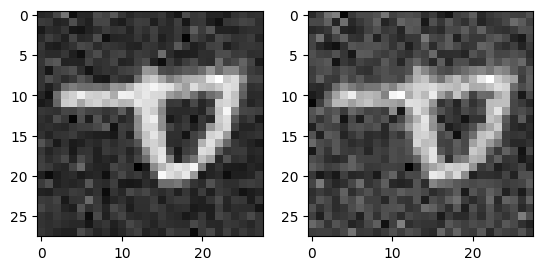

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 22357.688
batch loss value 22394.98
batch loss value 22089.777
batch loss value 22051.477
batch loss value 21981.158
batch loss value 21832.639
batch loss value 21497.123
iteration * batch_size: 345600 loss: 23550.779297
batch loss value 22273.465
batch loss value 22178.809
batch loss value 22044.316
batch loss value 21346.96
batch loss value 21874.54
saving iteration * batch_size: 352000 loss: 22979.894531
time step for image 62


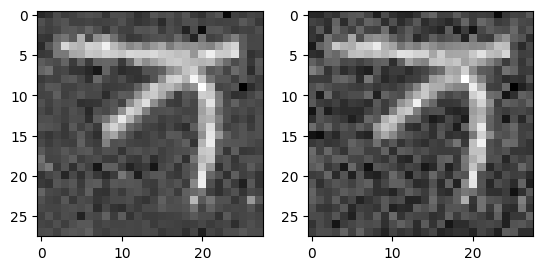

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 21584.482
batch loss value 22419.959
batch loss value 21593.723
batch loss value 21604.248
saving iteration * batch_size: 357120 loss: 22785.427734
time step for image 106


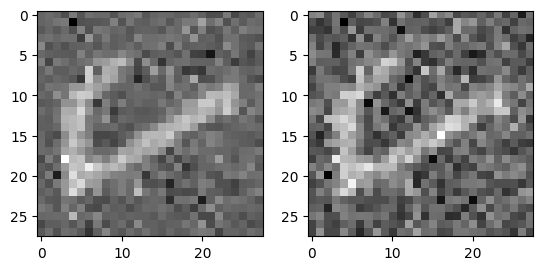

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value 22076.676
iteration * batch_size: 358400 loss: 23493.630859
batch loss value 21374.965
batch loss value 22128.7
batch loss value 21096.941
batch loss value 21874.309
batch loss value 21680.496


In [ ]:
data_noisy, data_in_batch, timestep, losses, avg_params = train_model(opt_state, params, avg_params, 'emnist.jax_version', train_new_model= train_new_model, energy_method=False, cont=False)
plt.plot(losses)

In [ ]:
## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L196
## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L78
posterior_variance = (betas) * (1 - alphas_prev_) / (1 - alphas_)
log_posterior_variance = jnp.log(jnp.hstack([posterior_variance[1], posterior_variance[1:]]))
posterior_variance_corrected = jnp.exp(log_posterior_variance)

strided_schedule = jnp.array(list(range(1, timesteps, 1)) + [timesteps])

alphas_strided_ = alphas_[strided_schedule]
alphas_prev_strided_ = jnp.pad(alphas_strided_[:-1], [1, 0], "constant", constant_values=1.0)

betas_strided = 1 - (alphas_strided_/alphas_prev_strided_)
posterior_variance_new_schedule = betas_strided * (1 - alphas_prev_strided_)/ (1-alphas_strided_)
log_posterior_variance = jnp.log(jnp.hstack([posterior_variance_new_schedule[1], posterior_variance_new_schedule[1:]]))
posterior_variance_new_schedule_corrected = jnp.exp(log_posterior_variance)

In [ ]:
mean_coeff_1 = jnp.sqrt(1-betas_strided)*(1 - alphas_prev_strided_) / (1 - alphas_strided_)
mean_coeff_2 = jnp.sqrt(alphas_prev_strided_) * betas_strided / (1 - alphas_strided_)

In [ ]:
def generate_data(avg_params, energy_method=False, clipped_version=False, labels=None):
    # final_step_data = get_noisy(data_transformed, timesteps-1)
    # mean_last_step = torch.mean(final_step_data, dim=1)
    # std_last_step = torch.std(final_step_data, dim=1)
    batch_size_generation = 1
    # (tensor([0.4086, 0.4253]), tensor([-0.6379,  0.0137])))
    key = jax.random.PRNGKey(42)
    # need to generate new keys everytime
    data_noisy = jax.random.normal(key, shape=(batch_size_generation, 28, 28, 1))
    data_orig = normalize(next(train)[0][0:batch_size_generation])
    data_noisy, _ = get_noisy(data_orig, jnp.array([timesteps]))
    
#     if not labels:
#       labelled_values = jnp.zeros((63, batch_size_generation))
#     elif labels=="circles":
#       labelled_values = torch.vstack([torch.ones(batch_size_generation), torch.zeros(batch_size_generation)])
#     elif labels=="moon":
#       labelled_values = torch.vstack([torch.zeros(batch_size_generation), torch.ones(batch_size_generation)])
#     elif labels=="mixed":
#       batch_size_generation_ = int(batch_size_generation/2)
#       labelled_values_1 = torch.vstack([torch.ones(batch_size_generation_), torch.zeros(batch_size_generation_)])
#       labelled_values_2 = torch.vstack([torch.zeros(batch_size_generation_), torch.ones(batch_size_generation_)])
#       labelled_values = torch.hstack([labelled_values_1, labelled_values_2])
      
    datas = []
    datas.append(jax.device_get(data_noisy))
    data_in_batch = data_noisy
    key = jax.random.PRNGKey(42)
    subkeys = jax.random.split(key, len(strided_schedule))                                 
    for t in range(1, len(strided_schedule)+1):
        stride_timestep = len(strided_schedule)-t
        timestep = strided_schedule[stride_timestep]
        t_repeated = jnp.repeat(jnp.array([timestep]), batch_size_generation)
        # data_stacked = torch.vstack([data_in_batch, labelled_values])
        pred_data = net.apply(avg_params, data_in_batch, t_repeated)
        if not clipped_version:
            if not energy_method:
                # optimization:: not sure if exp(log(x) - log(y)) instead of x/y helps numerically
                multiplier = jnp.exp(jnp.log((betas_strided[stride_timestep])) - jnp.log(jnp.sqrt(1- alphas_strided_[stride_timestep])))
                mean_data = jnp.subtract(data_in_batch, pred_data * multiplier)/jnp.sqrt(1-betas_strided[stride_timestep])
            else:
                ##
                # Energy function interpretation
                mean_data = jnp.add(data_in_batch, pred_data * betas_strided[stride_timestep])/jnp.sqrt(1-betas_strided[stride_timestep])
                ##
        else:
            # clipping an improvement as recommended in https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils.py#L171
            # this helps in improving the samples generated as it keeps the random variables in the range of -1 to +1
            if not energy_method:
                x_reconstructed = jnp.subtract(data_in_batch, pred_data * sd[timestep])/ jnp.sqrt(alphas_[timestep])
            else:
                # energy method and clipping to improve stabalization
                x_reconstructed = jnp.add(data_in_batch, pred_data * variance[timestep])/ jnp.sqrt(alphas_[timestep])

            if timestep >= 5:
                x_reconstructed = jnp.clip(x_reconstructed, -1., 1.)

            mean_data_1 = data_in_batch * mean_coeff_1[stride_timestep]
            mean_data_2 = x_reconstructed * mean_coeff_2[stride_timestep]
            mean_data = jnp.add(mean_data_1, mean_data_2)



        posterior_data = posterior_variance_new_schedule_corrected[stride_timestep]
        data_noisy = jax.random.normal(subkeys[t], shape=(batch_size_generation, 28, 28, 1))
        data_in_batch = jnp.add(mean_data,  jnp.sqrt(posterior_data) * data_noisy)
        datas.append(jax.device_get(data_in_batch))
    return datas, data_in_batch, data_orig

In [ ]:
datas, data_in_batch, data_orig = generate_data(avg_params, energy_method=False, clipped_version=True, labels="mixed")

In [ ]:
_, (plt1, plt2, plt3) = plt.subplots(1, 3)

show_image(unnormalize(data_in_batch[0]), plt1)
show_image(unnormalize(datas[0][0]), plt2)
show_image(unnormalize(data_orig[0]), plt3)

# data_noisy, _ = get_noisy(data_orig, jnp.array([60]))
# show_image(unnormalize(data_noisy[0]), plt1)

In [ ]:
huber_loss(datas[0], data_orig), huber_loss(data_in_batch, data_orig), huber_loss(data_in_batch, datas[50])

In [ ]:
%%capture 

fig = plt.figure()
ims = []
for data in datas:
    im = plt.imshow(data[0], cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=5, blit=True, repeat_delay=3000)
animate.save('gifs/diffusion_generation.gif')

In [ ]:
with open('gifs/diffusion_generation.gif','rb') as f:
  display(Image(data=f.read(), format='png'))